# Setup Inicial

In [11]:
#descargo archivos
! gdown 1Ui7dofcyVVJlqPSqnJjmufPKnZxw5ZAj #properatti.csv
! gdown 1I2V15Sf2mUqXQUQvExfvzipDxnWMqvXM #provincia.shx
! gdown 1Im6hNqTDb1zaCX4Lo9czGaMmqgzvDj9S #ar.csv
! gdown 1RCIHoEfk07OiSZw5PtOxVdj4aiHxQJpC #provincia.shp
! gdown 1EcVqccbr0qdJtuyzOHBRtSkkJZlxf6_Z #provincia.prj
! gdown 1r3ElDulmkTvdGwL6zuIWLZ08C8bM4kqw #provincia.dbf
! gdown 11VXNu7X_BIfB-2ZtStlxQmHoL_OBdafk #provincia.cpg

zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown
zsh:1: command not found: gdown


In [12]:
#instalo dependencias
# !pip install --upgrade geopandas pyshp shapely descartes
# !pip install --upgrade unidecode
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from unidecode import unidecode
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler   


<h3>Defino Funciones de Correlacion que luego utilizaremos</h3>

In [13]:
def calculate_correlation(dataframe, column1, column2, lower_bound1=None, lower_bound2=None, upper_bound1=None, upper_bound2=None):
    #If bounds are not given, calculate them
    if lower_bound1 is None or upper_bound1 is None:
        Q1 = dataframe[column1].quantile(0.25)
        Q3 = dataframe[column1].quantile(0.75)
        IQR = Q3 - Q1
        if lower_bound1 is None:
            lower_bound1 = Q1 - 1.5 * IQR
        if upper_bound1 is None:
            upper_bound1 = Q3 + 1.5 * IQR

    if lower_bound2 is None or upper_bound2 is None:
        Q1 = dataframe[column2].quantile(0.25)
        Q3 = dataframe[column2].quantile(0.75)
        IQR = Q3 - Q1
        if lower_bound2 is None:
            lower_bound2 = Q1 - 1.5 * IQR
        if upper_bound2 is None:
            upper_bound2 = Q3 + 1.5 * IQR

    #Filter out the outliers
    dataframe = dataframe[(dataframe[column1] >= lower_bound1) & (dataframe[column1] <= upper_bound1)]
    dataframe = dataframe[(dataframe[column2] >= lower_bound2) & (dataframe[column2] <= upper_bound2)]

    #Compute the correlation
    correlation = dataframe[[column1, column2]].corr().iloc[0,1]

    return correlation


#correlacion en grupos
def calculate_correlation_grouped(df, column1, column2, groupby_column,
                           lower_bound1=None, lower_bound2=None,
                           upper_bound1=None, upper_bound2=None):

    # Group the dataframe using groupby_column
    grouped = df.groupby(groupby_column)

    correlation_list = []
    for name, group in grouped:

        # Define lower and upper bounds from Interquartile range if not given
        if lower_bound1 is None or upper_bound1 is None:
            Q1 = group[column1].quantile(0.25)
            Q3 = group[column1].quantile(0.75)
            IQR = Q3 - Q1
            if lower_bound1 is None:
                lower_bound1 = Q1 - 1.5 * IQR
            if upper_bound1 is None:
                upper_bound1 = Q3 + 1.5 * IQR

        if lower_bound2 is None or upper_bound2 is None:
            Q1 = group[column2].quantile(0.25)
            Q3 = group[column2].quantile(0.75)
            IQR = Q3 - Q1
            if lower_bound2 is None:
                lower_bound2 = Q1 - 1.5 * IQR
            if upper_bound2 is None:
                upper_bound2 = Q3 + 1.5 * IQR

        # Filter outlier rows
        group = group[(group[column1] > lower_bound1) & (group[column1] < upper_bound1) &
                      (group[column2] > lower_bound2) & (group[column2] < upper_bound2)]

        # Check if the group has enough data to calculate correlation
        if group.shape[0] > 1 and group[column1].nunique() > 1 and group[column2].nunique() > 1:
            correlation = group[[column1, column2]].corr().iloc[0,1]
            correlation_list.append(correlation)

    # Check if you've found any valid correlations before calculating the mean
    if len(correlation_list) > 0:
        return np.mean(correlation_list)
    else:
        return None

#Análisis Preliminar #

In [14]:
properatti_df_original=pd.read_csv('../properatti.csv', sep=",", index_col=0)
properatti_df=properatti_df_original.copy()

<h3>Hacemos un paneo preliminar del dataset</h3>

In [15]:
#seteo para ver todas las colkumnas sin el "..."
pd.options.display.max_columns = None
#imprimo el head del df
properatti_df.head()

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,USD,2646675.0,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,95000.0,USD,1676227.5,95000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,64000.0,USD,1129248.0,64000.0,35.0,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


<h4>Observamos las columnas y sus tipos de datos utilizando el atributo</h4>
Observamos las distintas columnas del Dataframe con el atributo  Dataframe.dtypes


In [16]:
properatti_df.dtypes

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object

<h2>Aqui podemos ver que las columnas tienen el tipo de dato esperado, estando todas las columnas que representan numeros en formato float64</h2>

In [17]:
properatti_df.count()

operation                     121220
property_type                 121220
place_name                    121197
place_with_parent_names       121220
country_name                  121220
state_name                    121220
geonames_id                   102503
lat-lon                        69670
lat                            69670
lon                            69670
price                         100810
currency                      100809
price_aprox_local_currency    100810
price_aprox_usd               100810
surface_total_in_m2            81892
surface_covered_in_m2         101313
price_usd_per_m2               68617
price_per_m2                   87658
floor                           7899
rooms                          47390
expenses                       14262
properati_url                 121220
description                   121218
title                         121220
image_thumbnail               118108
dtype: int64

<h3>A primera vista, podemos ver que todos nuestros entries tienen valores en las columnas operation, property_type, place_with_parent_names, country_name, state_name, properati_url y title</h3>
<h3>Definimos estrategia para las columnas:</h3>
<h4><u>Operation</u></h4>
<h5>Veremos el tipo de operaciones que estan presentes en el DataFrame y normalizaremos si es necesario</h5>
<h4><u>property_type</u></h4>
<h5>Veremos los distintos tipos de propiedades, normalizaremos de ser necesario. Esta columna es importante ya que luego para analisis de precio seguramente sea necesario discriminar</h5>
<h4><u>geonames_id, lat-lon, lat y lon</u></h4>
<h5>Limpiaremos y utilizaremos esta informacion para visualizar la ubicacion de las propiedades. La informacion de la geografia se complementa con informacion proveniente de un dataframe extra (DATA_GEONAMES) y dos mapas de Argentina, uno con division politica y otro continental.</h5>
<h4><u>place_with_parent_names</u></h4>
<h5>Normalizaremos esta columna, para obtener informacion acerca de la ubicacion en terminos de provincia, ciudad y barrio. Dicha informacion se guardara en columnas nuevas.</h5>
<h4><u>price, currency, price_aprox_local_currency,price_aprox_usd</u></h4>
<h5>Normalizaremos en una nueva columna con precio aproximado en usd, utilizando el valor de la columna price_aprox_usd, intentando extraer via regex de la columna descripcion, o convirtiendo los valores en caso de que esten en otra moneda</h5>
<h4><u>surface_total_in_m2</u></h4>
<h5>Crearemos una nueva columna con los valores de la columna original y extrayendo los faltantes que se puedan encontrar, mediante una regex, en las columnas descripción, title y url.</h5>
<h4><u>Columna</u></h4>
<h5>Estrategia</h5>
<h4><u>Columna</u></h4>
<h5>Estrategia</h5>
<h4><u>Columna</u></h4>
<h5>Estrategia</h5>
<h4><u>Columna</u></h4>
<h5>Estrategia</h5>
<h4><u>Columna</u></h4>
<h5>Estrategia</h5>





#limpieza preliminar

In [18]:
df_num_of_entries = properatti_df.shape[0]
df_num_of_entries_no_duplicates = properatti_df.drop_duplicates().shape[0]

print("Numero de filas en el Dataframe original:", df_num_of_entries)
print("Numero de filas en el Dataframe sin duplicados:", df_num_of_entries)

Numero de filas en el Dataframe original: 121220
Numero de filas en el Dataframe sin duplicados: 121220


Podemos ver que no tenemos duplicados en nuestro dataframe

In [19]:
#aplico mascara de operation = sell  y miro cuantas entries son
df_operation = properatti_df[properatti_df['operation']=='sell']
print(f"Numero de operaciones de 'sell' = {df_operation.shape[0]}")


Numero de operaciones de 'sell' = 121220


Podemos ver que todas las operaciones son de Ventas, ya que la unica key del atributo groups de nuestro objeto DataFrameGroupBy es "sell", por lo cual quitamos la columna del dataframe

In [20]:
properatti_df.drop('operation', axis=1, inplace=True)

In [21]:
# busco publicaciones que tengan palabras que sugieran publicaciones de tipo lote de multiples propiedades, las cual no nos interesa ya que contaminan el dataset
search_strings = ["unidades", "departamentos", " uds", "deptos"]

# Concatenate the title and description columns and convert them to lowercase for case-insensitive search
title_lower = properatti_df['title'].str.lower()

# Creo mascara para detectar si la columna title tiene alguna de mis palabras a buscar
mask_search_string = title_lower.str.contains('|'.join(search_strings))

# Filter the DataFrame based on the mask
multiple_filter_df = properatti_df[mask_search_string]

# imprimo las primeras 100 descripciones de entries que cumplan mi mascara para analizarlas
row_iterator=0
for index, row in multiple_filter_df.iterrows():
  if row_iterator>100:
    break
  print(f"Index: {index}\nTitle: {row['title']}\nDescription: {row['description']}\nRooms: {row['rooms']}\nFloor: {row['floor']}\nPrice: {row['price_aprox_usd']}\n\n")
  row_iterator+=1


Index: 41
Title: Venta en pozo deptos-dúplex- Barrio Santa Rita del Lago
Description: “Arecas” es un complejo de dúplex y departamentos de primera calidad constructiva ubicado en el mejor Barrio Residencial de Villa Carlos Paz. Pensamos en brindarles una opción acorde a cada necesidad: para la persona o familia que busca su vivienda, el ahorrista que elige una vivienda en construcción para capitalizarse y el inversionista que apuesta a la excelente renta que ofrece la Villa en alquileres temporarios. • Financiación: FINANCIACIÓN PROPIA | MÁX. RENTABILIDAD 100% PESOS | CUOTAS CONVENIDAS • Ubicación privilegiada a metros de la Costanera del Lago San Roque . • Departamentos de 1, 2 y 3 dorm. • Barrio con zona comercial propia • Calidad constructiva • Entrega pactada• Desarrollo: MP Innovación & Desarrollo • Comercializadora: MAM InmobiliariaBONIFICACIÓN POR PAGO DE CONTADO- Consulte:- 351-7061857 (Maria)- 86 (Noelia)
Rooms: 4.0
Floor: nan
Price: nan


Index: 100
Title: Rosario - San Nicol

In [22]:
print(multiple_filter_df.shape[0])

1313


Vemos que la mayoria de estas entries son efectivamente publicaciones de pozo, o de multiples departamentos a la vez, y al ver que son 1313, decidimos retirarlas del Dataframe sobre el cual trabajaremos

In [23]:
properatti_df = properatti_df[~mask_search_string]
print(properatti_df.shape[0])

119907


# Rooms

In [24]:
#paso a lowercase las columnas a analizar
properatti_df['description'] = properatti_df['description'].str.lower()
properatti_df['title'] = properatti_df['title'].str.lower()


<h1>VEMOS 73830 DATOS NO VALIDOS</h1>

In [25]:
filtered_df = properatti_df[(properatti_df['rooms'].isnull())]

# Filtramos los datos no validos
print(filtered_df.shape[0])
print(filtered_df['rooms'].isnull().sum())

73156
73156


In [26]:
pattern_space_between = re.compile(r'(\d+)\s*amb')
pattern_space_after_dot = re.compile(r'\.(?!\s)')
def remove_whitespace_between_number_and_amb(text):
    # Define a regular expression pattern to match "<number> amb" with optional white spaces


    result = re.sub(pattern_space_after_dot, '. ', text)
    # Use re.sub to replace matched patterns with "<number>amb"
    result = re.sub(pattern_space_between, r'\1amb', result)

    return result



#definimos funcion para reemplazar palabras
def replace_words_in_column(df, column_name, word_replacements):
    for word, replacement in word_replacements:
        df[column_name] = df[column_name].str.replace(rf'{word}', str(replacement))

    return df

# definimos funcion para extraer numero
def extract_substring(text, regex_pattern):
  matches = re.findall(regex_pattern, text)

  if matches:
    numbers = [int(n) for n in matches if int(n)<15]

    if numbers:
      return max(numbers)
    else:
      return ""
  else:
    return ""

In [27]:
print(remove_whitespace_between_number_and_amb("3.2 amb, 8 ambasdlk 9 2 amb"))

3. 2amb, 8ambasdlk 9 2amb


In [28]:
#definimos las palabras a reemplazar
word_replacements = [
    ('un', 1),
    ('mono', 1),
    ('dos', 2),
    ('tres', 3),
    ('cuatro', 4),
    ('cinco', 5),
    ('seis', 6),
    ('siete', 7),
    ('ocho', 8),
    ('nueve', 9)
]
#aplicamos nuestro filtro a title
filtered_df = replace_words_in_column(filtered_df,"title",word_replacements)
#aplicamos la remocion de whitespaces entre numeros y amb
filtered_df['title'] = filtered_df['title'].apply(lambda x: remove_whitespace_between_number_and_amb(x))

#aplicamos nuestro filtro a description
filtered_df = replace_words_in_column(filtered_df,"description",word_replacements)
#aplicamos la remocion de whitespaces entre numeros y amb
filtered_df['description'] = filtered_df['description'].apply(str).apply(lambda x: remove_whitespace_between_number_and_amb(x))


/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/1050586170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].str.replace(rf'{word}', str(replacement))
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2833574507.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['title'] = filtered_df['title'].apply(lambda x: remove_whitespace_between_number_and_amb(x))
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/28335745

<h1>Normalizamos title para que contenga {numero}amb</h1>

In [29]:
#pattern para encontrar{numero}amb
pattern = re.compile(r'(\d+)amb')

filtered_df['title_short'] = filtered_df['title'].apply(lambda x: extract_substring(x, pattern))
filtered_df['description_short'] = filtered_df['description'].apply(lambda x: extract_substring(x, pattern))
print(filtered_df.shape)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2104243757.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['title_short'] = filtered_df['title'].apply(lambda x: extract_substring(x, pattern))


(73156, 26)


/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2104243757.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['description_short'] = filtered_df['description'].apply(lambda x: extract_substring(x, pattern))


In [30]:
filtered_df['title_short'] = pd.to_numeric(filtered_df['title_short'], errors='coerce')
filtered_df['description_short'] = pd.to_numeric(filtered_df['description_short'], errors='coerce')
filtered_df['rooms'] = filtered_df['rooms'].combine_first(filtered_df['title_short'])
filtered_df['rooms'] = filtered_df['rooms'].combine_first(filtered_df['description_short'])


/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/4292333989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['title_short'] = pd.to_numeric(filtered_df['title_short'], errors='coerce')
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/4292333989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['description_short'] = pd.to_numeric(filtered_df['description_short'], errors='coerce')
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/429

In [31]:
value_counts = filtered_df['rooms'].value_counts()
print(value_counts)

rooms
2.0     7864
3.0     7626
1.0     5893
4.0     4590
5.0     1488
6.0      426
7.0      160
8.0       34
9.0       17
11.0       8
10.0       8
14.0       4
12.0       3
Name: count, dtype: int64


In [32]:
# Filter dataframe
filtered_df_rooms = filtered_df[filtered_df['rooms'] == 20172.0]
value_counts = filtered_df_rooms['rooms'].value_counts()
print(value_counts)

for description in filtered_df_rooms['description']:
    print(description)

Series([], Name: count, dtype: int64)


In [33]:
print(filtered_df['rooms'].isnull().sum())
filtered_df.loc[filtered_df['rooms'] > 30, 'rooms'] = np.nan
print(filtered_df['rooms'].isnull().sum())
value_counts = filtered_df['rooms'].value_counts()
print(value_counts)

45035
45035
rooms
2.0     7864
3.0     7626
1.0     5893
4.0     4590
5.0     1488
6.0      426
7.0      160
8.0       34
9.0       17
11.0       8
10.0       8
14.0       4
12.0       3
Name: count, dtype: int64


# Ubicaciones (Juan)

In [34]:
# En el dataframe properatti_df, la informacion relevante para limpiar relacionada a la geografia esta distribuida en 4 columnas:
  # geonames_id, lat,	lon, y	lat-lon

# Se limpiarán los datos relacionados a la geografia, con el objetivo de:
  # poder graficar cada propiedad como un punto en un mapa. El mapa puede ser de todo el pais, por provincia o por region.
  # poder utilizar datos geograficos para realizar analisis exploratorios (ej., histograma de precios por ciudad, provincia, etc.)

# la estrategia para limpiar la geografia va a ser:
  # Imputar en la medida de lo posible la informacion de ubicación geografica (latitud y longitud) sobre las columnas 'lat' y 'lon' para todas las propiedades.
  # cuando no haya informacion en estos campos, tratar de recolectarla del geodataframe 'DATA_GEONAMES' (https://www.geonames.org/countries/AR/argentina.html)
    # Esto se hara de dos maneras:
      # la primera, trayendo la informacion de latitud y longitud de DATA_GEONAMES que coincida con el identificador de geonames de la propiedad.
      # Cuando esto no sea posible, se entrecruzará la informacion de ciudad o provincia de cada propiedad con la del dataframe DATA_GEONAMES, para traer la informacion de lat y lon correspondiente.
      # (esto es una aproximacion, ya que para cada propiedad, los valores de latitud y longitud seran los de la ciudad o provincia correspondiente)
    # Para esto, se limpiará la columna 'place_with_parent_names', y la información se distribuirá en cuatro columnas nuevas:
      # provincia, partido, ciudad y barrio.

properatti_df[['title','geonames_id','lat','lon', 'lat-lon']]

,title,geonames_id,lat,lon,lat-lon
0,2 amb tipo casa sin expensas en pb,3430787.0,-34.661824,-58.508839,"-34.6618237,-58.5088387"
1,venta depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,3432039.0,-34.903883,-57.964330,"-34.9038831,-57.9643295"
2,2 amb 3er piso con ascensor apto credito,3430787.0,-34.652262,-58.522982,"-34.6522615,-58.5229825"
3,ph 3 amb. cfte. reciclado,3431333.0,-34.647797,-58.516424,"-34.6477969,-58.5164244"
4,depto 2 amb al contrafrente zona centro/plaza ...,3435548.0,-38.002626,-57.549447,"-38.0026256,-57.5494468"
...,...,...,...,...,...
121215,torre forum alcorta- impecable 3 ambientes,3436077.0,NaN,NaN,NaN
121216,ruca inmuebles | venta | lomas de san isidro |...,3436080.0,NaN,NaN,NaN
121217,venta departamento ambiente divisible a estren...,3433775.0,-34.570639,-58.475596,"-34.5706388726,-58.4755963355"
121218,2 amb. c/ dep. de servicio al contrafrente| re...,NaN,NaN,NaN,NaN


In [35]:
# importo el Mapa de Argentina CON info por provincias

data_location = "./provincias/provincia.shx"
mapa_argentina = gpd.read_file(data_location)

# importo el Mapa (2) de Argentina SIN info por provincias

mundo = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
mapa_argentina_2 = mundo[mundo.name == "Argentina"]

mapa_argentina.head(24)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/3730548221.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  mundo = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


,gid,entidad,fna,gna,nam,in1,fdc,sag,geometry
0,1,0,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma,Ciudad Autónoma de Buenos Aires,02,Geografía,IGN,"POLYGON ((-58.45535 -34.52776, -58.45404 -34.5..."
1,2,0,Provincia del Neuquén,Provincia,Neuquén,58,Geografía,IGN,"POLYGON ((-70.39341 -36.15624, -70.39333 -36.1..."
2,3,0,Provincia de San Luis,Provincia,San Luis,74,Geografía,IGN,"POLYGON ((-67.05547 -31.85605, -67.05000 -31.8..."
3,4,0,Provincia de Santa Fe,Provincia,Santa Fe,82,Geografía,IGN,"POLYGON ((-61.04639 -27.99800, -61.00805 -27.9..."
4,5,0,Provincia de La Rioja,Provincia,La Rioja,46,Geografía,IGN,"POLYGON ((-68.52136 -27.81792, -68.52148 -27.8..."
5,6,0,Provincia de Catamarca,Provincia,Catamarca,10,Geografía,IGN,"POLYGON ((-68.50537 -25.16851, -68.50386 -25.1..."
6,7,0,Provincia de Tucumán,Provincia,Tucumán,90,Geografía,IGN,"POLYGON ((-65.35915 -26.05944, -65.35868 -26.0..."
7,8,0,Provincia del Chaco,Provincia,Chaco,22,Geografía,IGN,"POLYGON ((-62.32434 -24.12318, -62.31959 -24.1..."
8,9,0,Provincia de Formosa,Provincia,Formosa,34,Geografía,IGN,"POLYGON ((-62.31201 -22.48666, -62.31056 -22.4..."
9,10,0,Provincia de Santa Cruz,Provincia,Santa Cruz,78,Geografía,IGN,"MULTIPOLYGON (((-67.59361 -46.01744, -67.59357..."


<AxesSubplot:>

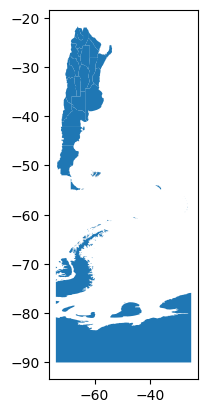

In [36]:
# este mapa trae los poligonos de cada provincia.

mapa_argentina.plot()

<AxesSubplot:>

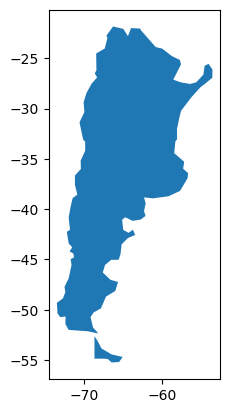

In [37]:
# este mapa no trae info de provincias (mas practico para ploteo general de todas las propiedades)

mapa_argentina_2.plot()

In [38]:
# Traemos el geodataframe 'data_geonames'

location_geonames = './provincias/AR/AR.csv'
data_geonames = gpd.read_file(location_geonames, sep='\t')

print(data_geonames.shape)

(52562, 20)


In [39]:
subset_data = data_geonames.iloc[:, 0:7]  # Selecciona las columnas del 0 al 10 (inclusivo)
subset_data.sample(10)  # Selecciona una muestra aleatoria de 10 filas

,GEONAMEID,NAME,ASCIINAME,ALTNAMES,LATITUDE,LONGITUDE,FEATCLASS
4272,3431487,Puesto La Unión,Puesto La Union,,-24.81964,-59.82946,S
28961,3851680,Estancia La Elena,Estancia La Elena,,-31.21684,-60.42131,S
41926,3864700,Arroyo Barrancoso,Arroyo Barrancoso,,-32.94924,-60.02886,H
50129,12548832,La Angostura,La Angostura,La Angostura,-43.32811,-65.54124,P
37496,3860250,Cordobita,Cordobita,"Cordobita,La Cordobita",-28.30568,-67.21783,P
750,3427953,Puesto Siete Árboles,Puesto Siete Arboles,,-25.87101,-59.68892,S
29675,3852395,La Calavera,La Calavera,,-24.43333,-62.20000,L
26371,3849086,Estancia La Reacción,Estancia La Reaccion,,-38.71626,-60.89138,S
33554,3856294,Puesto El Vinal,Puesto El Vinal,,-23.61667,-61.21667,S
9565,3832200,Cerro Yungara Sur,Cerro Yungara Sur,Cerro Yungara Sur,-23.52401,-66.61686,T


In [40]:
# Se hacen algunos ajustes al dataframe DATA_GEONAMES:
# Primero, convierto a float64 la columna 'GEONAMEID' que es un string. Dicha columna se usara para matchear con 'geonames_id' en properatti_df (float64).

data_geonames['GEONAMEID'] = pd.to_numeric(data_geonames['GEONAMEID'], errors='coerce').astype(float)

In [41]:
# Segundo, utilizo la informacion de 'TIMEZONE' para crear una columna llamada 'provincia'. Dicha columna se usara para matchear con 'provincia' en properatti_df (object)).

pattern = re.compile(r'/([^/]+)$')

def cambiar_nombre(timezone):
    match = re.search(pattern, timezone)
    return match.group(1).replace('_', ' ') if match else None

data_geonames['provincia'] = data_geonames['TIMEZONE'].apply(lambda x: cambiar_nombre(x))
data_geonames.head(10)

,GEONAMEID,NAME,ASCIINAME,ALTNAMES,LATITUDE,LONGITUDE,FEATCLASS,FEATCODE,COUNTRY,CC2,ADMIN1,ADMIN2,ADMIN3,ADMIN4,POPULATION,ELEVATION,GTOPO30,TIMEZONE,MODDATE,geometry,provincia
0,3427200.0,Sierra del 15,Sierra del 15,,-37.96613,-57.94670,T,HLL,AR,,01,06357,,,0.0,NaN,200,America/Argentina/Buenos_Aires,2016-01-30,POINT (-57.94670 -37.96613),Buenos Aires
1,3427201.0,Puesto 1 Napoleón Cué,Puesto 1 Napoleon Cue,,-28.63333,-56.11667,S,HSE,AR,,06,18168,,,0.0,NaN,79,America/Argentina/Cordoba,2016-01-30,POINT (-56.11667 -28.63333),Cordoba
2,3427202.0,Cañada del Zorro,Canada del Zorro,,-32.16667,-59.50000,H,STM,AR,,08,,,,0.0,NaN,65,America/Argentina/Cordoba,1993-12-21,POINT (-59.50000 -32.16667),Cordoba
3,3427203.0,Estancia Zorraquín,Estancia Zorraquin,,-31.51553,-58.55208,S,RNCH,AR,,08,30113,,,0.0,NaN,71,America/Argentina/Cordoba,2016-01-30,POINT (-58.55208 -31.51553),Cordoba
4,3427204.0,Estancia Zequeira Cué,Estancia Zequeira Cue,,-28.43825,-56.08838,S,RNCH,AR,,06,18168,,,0.0,NaN,98,America/Argentina/Cordoba,2016-01-30,POINT (-56.08838 -28.43825),Cordoba
5,3427205.0,Arroyo Zequeira,Arroyo Zequeira,,-27.83789,-56.08614,H,STM,AR,,06,,,,0.0,NaN,96,America/Argentina/Cordoba,2011-04-19,POINT (-56.08614 -27.83789),Cordoba
6,3427206.0,Zenón Videla Dorna,Zenon Videla Dorna,"Z. Videla Dorna,Zenon Videla Dorna,Zenón Videl...",-35.54208,-58.88645,P,PPL,AR,,01,06547,,,0.0,NaN,26,America/Argentina/Buenos_Aires,2023-12-11,POINT (-58.88645 -35.54208),Buenos Aires
7,3427207.0,Zenón Roca,Zenon Roca,"Zenon Roca,Zenón Roca",-31.54708,-58.77304,P,PPL,AR,,08,30113,,,0.0,NaN,71,America/Argentina/Cordoba,2023-12-11,POINT (-58.77304 -31.54708),Cordoba
8,3427208.0,Zelaya,Zelaya,Zelaya,-34.37052,-58.86938,P,PPL,AR,,01,06638,,,0.0,NaN,21,America/Argentina/Buenos_Aires,2023-12-11,POINT (-58.86938 -34.37052),Buenos Aires
9,3427209.0,Arroyo de la Zarza,Arroyo de la Zarza,,-32.13507,-59.85856,H,STM,AR,,08,,,,0.0,NaN,62,America/Argentina/Cordoba,2011-04-19,POINT (-59.85856 -32.13507),Cordoba


In [42]:
# chequeo de valores nulos en las columnas de la geografia:

mask_lat_lon = np.logical_and(properatti_df['lat'].isnull(), properatti_df['lon'].isnull())
mask_latlon = properatti_df['lat-lon'].isnull()
mask_geonames = properatti_df['geonames_id'].isnull()
combined_mask = mask_lat_lon & mask_geonames


geografia_filtered_df = properatti_df.loc[mask_lat_lon]
print("nulls en 'lat' y 'lon': " f"{geografia_filtered_df.shape}")
geografia_filtered_df = properatti_df.loc[mask_latlon]
print("nulls en 'lat-lon': " f"{geografia_filtered_df.shape}")
# 'lat', 'lon' y 'lat-lon' tienen la misma info

geografia_filtered_df = properatti_df.loc[mask_geonames]
print("nulls en 'geonames_id': " f"{geografia_filtered_df.shape}")
geografia_filtered_df = properatti_df.loc[combined_mask]
print("ninguna informacion: " f"{geografia_filtered_df.shape}")




nulls en 'lat' y 'lon': (51180, 24)
nulls en 'lat-lon': (51180, 24)
nulls en 'geonames_id': (18629, 24)
ninguna informacion: (8158, 24)


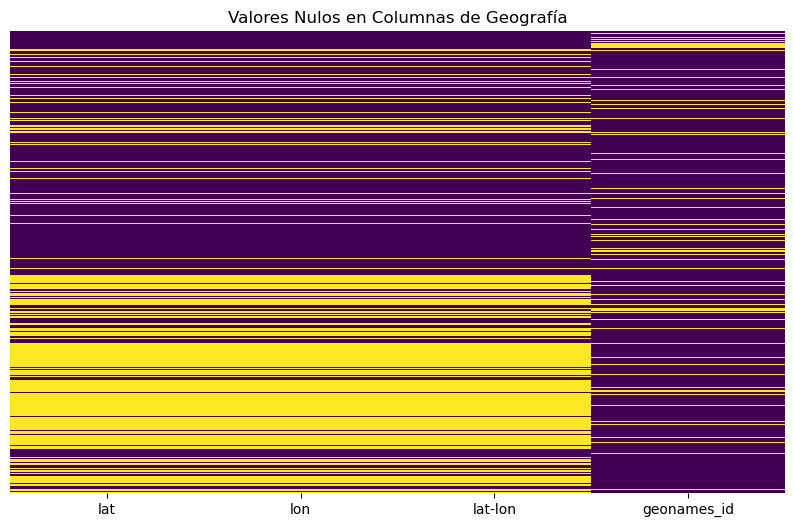

In [43]:
# Estado de los valores nulos al comienzo del proceso.

nulls_df = properatti_df[['lat', 'lon', 'lat-lon', 'geonames_id']].isnull()

# Plotear los valores nulos en un heatmap abarcando todo el dataframe.

plt.figure(figsize=(10, 6))
sns.heatmap(nulls_df, cmap='viridis', cbar=False, yticklabels=False)
plt.title('Valores Nulos en Columnas de Geografía')
plt.show()

# Se ve claramente que 'lat', 'lon' y 'lat-lon' son redundantes, es decir tienen la misma informacion. La diferencia es que 'lat-lon' tiene los valores 'lat' y 'lon' en forma de lista.

In [44]:
# Un pantallazo a la columna 'place_with_parent_names' muestra que es en principio la informacion sobre la provincia (cuando se trata de Buenos Aires, tambien hay informacion sobre el partido), ciudad, y en algunos casos barrio.
# Esta informacion me va a servir para cruzar datos con DATA GEONAMES, cuando no haya informacion de 'lat' y 'lon'.

properatti_df['place_with_parent_names'].value_counts()

place_with_parent_names
|Argentina|Santa Fe|Rosario|                                                     8398
|Argentina|Córdoba|Córdoba|                                                      6509
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|                           6476
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nordelta|                              3315
|Argentina|Capital Federal|Belgrano|                                             2974
                                                                                 ... 
|Argentina|Bs.As. G.B.A. Zona Norte|San Fernando|Islas|                             1
|Argentina|Bs.As. G.B.A. Zona Norte|San Fernando|Barrio Cerrado "La Damasia"|       1
|Argentina|La Rioja|Villa Unión|                                                    1
|Argentina|Mendoza|Los Corralitos|                                                  1
|Argentina|Bs.As. G.B.A. Zona Sur|Berazategui|Altos de Hudson I|                    1
Name: count, Length: 1163, dty

In [45]:
# Chequeo si falta algun dato en 'place_with_parent_names'

properatti_df.place_with_parent_names.isnull().sum()

# Todos tienen algun tipo de informacion de lugar(pais provincia ciudad)

0

In [46]:
# Filtro los acentos en DATA_GEONAMES y en properatti_df, para que si hay que matchear, no haya diferencias por acentos.

columns_2 = ['place_with_parent_names']
columns_1 = ['NAME', 'ASCIINAME', 'provincia']

def remove_accents(text):
    return unidecode(text) if pd.notna(text) else text

properatti_df[columns_2] = properatti_df[columns_2].applymap(remove_accents)
data_geonames[columns_1] = data_geonames[columns_1].applymap(remove_accents)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2556021755.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  properatti_df[columns_2] = properatti_df[columns_2].applymap(remove_accents)
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2556021755.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_geonames[columns_1] = data_geonames[columns_1].applymap(remove_accents)


In [47]:
# Asigno la informacion de 'place_with_parent_name' a tres nuevas columnas: 'provincia', 'ciudad' y 'barrio'

pattern = re.compile(r'\|(?P<pais>[^|]+)\|(?P<provincia>[^|]+)(?:\|(?P<ciudad>[^|]+))?(?:\|(?P<barrio>[^|]+))?')

def extract_parts(location_info):
    match = pattern.match(location_info)
    return {'provincia': match.group('provincia') if match else None, 'ciudad': match.group('ciudad') if match else None, 'barrio': match.group('barrio') if match else None}

properatti_df[['provincia', 'ciudad', 'barrio']] = properatti_df['place_with_parent_names'].apply(
    lambda x: pd.Series(extract_parts(x))
)




In [48]:
# Mando a Capital Federal adentro de la Provincia de Buenos Aires (por razones geograficas -no administrativas-)

def clean_capital(row):
    if row['provincia'] == 'Capital Federal':
        row['provincia'] = 'Buenos Aires'
        row['barrio'] = row['ciudad']
        row['ciudad'] = 'Ciudad Autonoma de Buenos Aires'
    return row

properatti_df = properatti_df.apply(clean_capital, axis=1)

In [49]:
# resultado de limpiar 'place_with_parent_names'

properatti_df[['title','provincia','ciudad','barrio']].head(10)

,title,provincia,ciudad,barrio
0,2 amb tipo casa sin expensas en pb,Buenos Aires,Ciudad Autonoma de Buenos Aires,Mataderos
1,venta depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,Bs.As. G.B.A. Zona Sur,La Plata,None
2,2 amb 3er piso con ascensor apto credito,Buenos Aires,Ciudad Autonoma de Buenos Aires,Mataderos
3,ph 3 amb. cfte. reciclado,Buenos Aires,Ciudad Autonoma de Buenos Aires,Liniers
4,depto 2 amb al contrafrente zona centro/plaza ...,Buenos Aires Costa Atlantica,Mar del Plata,Centro
5,"casa barrio 338. sobre calle 3 de caballería, ...",Entre Rios,Gualeguaychu,None
6,"muy buen ph al frente dos dormitorios , patio,...",Bs.As. G.B.A. Zona Norte,Vicente Lopez,Munro
7,jose hernandez 1400 monoambiente estrenar cat...,Buenos Aires,Ciudad Autonoma de Buenos Aires,Belgrano
8,"jose hernandez 1400 dos ambientes estrenar ,...",Buenos Aires,Ciudad Autonoma de Buenos Aires,Belgrano
9,white 7637 - 2 dormitorios con patio,Santa Fe,Rosario,None


In [50]:
# Vemos que cuando la provincia es Buenos Aires, el dato nos queda sucio, con informacion sobre el partido.
properatti_df['provincia'].value_counts()

provincia
Buenos Aires                    31942
Bs.As. G.B.A. Zona Norte        25408
Bs.As. G.B.A. Zona Sur          13808
Cordoba                         11856
Santa Fe                        10043
Buenos Aires Costa Atlantica     9906
Bs.As. G.B.A. Zona Oeste         9242
Buenos Aires Interior            2256
Rio Negro                         791
Neuquen                           720
Tucuman                           670
Mendoza                           655
Corrientes                        583
Misiones                          457
Entre Rios                        360
Salta                             278
Chubut                            258
San Luis                          250
La Pampa                          154
Formosa                            65
Chaco                              54
San Juan                           39
Tierra Del Fuego                   31
Catamarca                          27
Jujuy                              26
Santa Cruz                         20
Sa

In [51]:
# Uso regex para limpiar Buenos Aires, enviando la informacion subsiguiente a una nueva columna 'partido'
pattern = re.compile(r'(?P<provincia>Bs\.As\.|Buenos Aires)\s(?P<partido>.+)')

def match_location(location_info):
    if pd.isna(location_info):  # Chequea valores faltantes
        return pd.Series({'provincia': None, 'partido': None})

    match = pattern.match(location_info)
    if match:
        provincia = 'Buenos Aires'
        partido = match.group('partido')
        return pd.Series({'provincia': provincia, 'partido': partido})
    else:
        return pd.Series({'provincia': location_info, 'partido': None})


properatti_df[['provincia', 'partido']] = properatti_df['provincia'].apply(match_location)

In [52]:
# Vemos que ahora, el dato Buenos Aires aparece unificado, y el resto de la informacion aparece en 'partido'
properatti_df[['provincia','partido']].value_counts()

provincia     partido          
Buenos Aires  G.B.A. Zona Norte    25408
              G.B.A. Zona Sur      13808
              Costa Atlantica       9906
              G.B.A. Zona Oeste     9242
              Interior              2256
Name: count, dtype: int64

In [53]:
# Pantallazo al campo 'ciudad' correspondiente a 'provincia' == Buenos Aires
properatti_df[properatti_df['provincia'] == 'Buenos Aires']['ciudad'].value_counts()

ciudad
Ciudad Autonoma de Buenos Aires    31942
Tigre                               8940
Mar del Plata                       7646
Vicente Lopez                       3651
Lomas de Zamora                     3449
                                   ...  
Reta                                   1
Laprida                                1
Villarino                              1
Mar de Cobo                            1
General Paz                            1
Name: count, Length: 128, dtype: int64

In [54]:
# Primer paso para imputar valores nulos en 'lat' y 'lon':

# Matchea los valores de 'geonames_id' en el dataframe 'data_geonames'
# cuando los encuentra, se trae el valor de las columnas 'LATITUDE' y 'LONGITUDE'

def normalize_geonameid(row):
    if pd.isnull(row['lat']) and pd.isnull(row['lon']):
        geoname_id = row['geonames_id']
        if geoname_id in data_geonames['GEONAMEID'].values:
            matching_row = data_geonames[data_geonames['GEONAMEID'] == geoname_id]
            if not matching_row.empty:
                row.loc['lat'] = matching_row['LATITUDE'].iloc[0]
                row.loc['lon'] = matching_row['LONGITUDE'].iloc[0]

    return row

properatti_df = properatti_df.apply(normalize_geonameid, axis=1)

In [55]:
properatti_df[['lat', 'lon']].isnull().sum()

lat    8319
lon    8319
dtype: int64

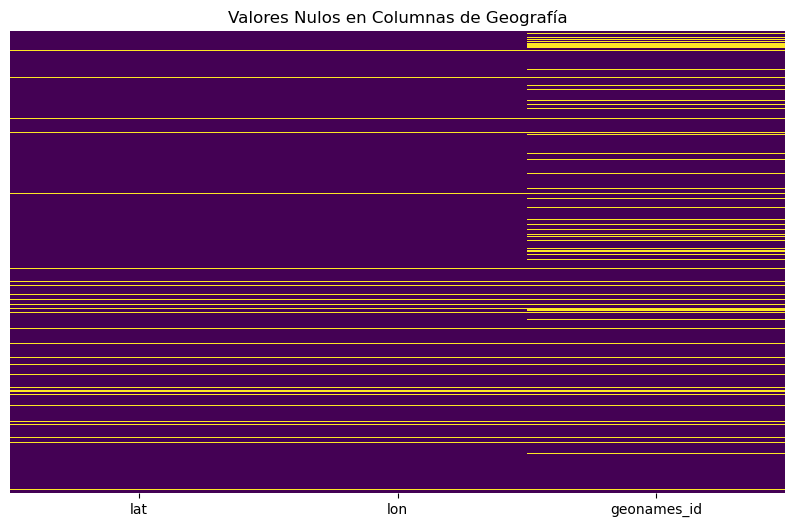

In [56]:
# Estado de los valores nulos al final del primer paso

nulls_df = properatti_df[['lat', 'lon', 'geonames_id']].isnull()
plt.figure(figsize=(10, 6))
sns.heatmap(nulls_df, cmap='viridis', cbar=False, yticklabels=False)
plt.title('Valores Nulos en Columnas de Geografía')
plt.show()

# La reduccion de nulos es considerable.

In [57]:
# Segundo paso:
# Entrecruzo las columnas 'ciudad' y 'NAME' en DATA_GEONAMES (tiene informacion de ciudad).
# Si hay matches, me traigo los valores 'LATITUDE' y 'LONGITUDE' de data_geonames.

def find_ciudad_province_in_data_geonames(row):
    if pd.isnull(row['lat']) and pd.isnull(row['lon']):
        ciudad = row['ciudad']
        matching_rows = data_geonames[data_geonames['NAME'].isin([ciudad])]

        if not matching_rows.empty:
            matching_row = matching_rows.iloc[0]
            row['lat'] = pd.to_numeric(matching_row['LATITUDE']).astype(float)
            row['lon'] = pd.to_numeric(matching_row['LONGITUDE']).astype(float)

    return row

properatti_df = properatti_df.apply(find_ciudad_province_in_data_geonames, axis=1)

In [58]:
# La reducción de nulos es significativa.

properatti_df[['lat', 'lon']].isnull().sum()

lat    371
lon    371
dtype: int64

In [59]:
# Tercer paso:
# Entrecruzo las columnas 'provincia' (properatti_df) y 'provincia' en DATA_GEONAMES (campo creado a partir de 'TIMEZONE' que tiene info de provincias).
# Si hay matches, me traigo los valores 'LATITUDE' y 'LONGITUDE' de data_geonames.

def find_ciudad_province_in_data_geonames(row):
    if pd.isnull(row['lat']) and pd.isnull(row['lon']):
        provincia = row['provincia']
        matching_rows = data_geonames[data_geonames['provincia'].isin([provincia])]

        if not matching_rows.empty:
            matching_row = matching_rows.iloc[0]
            row['lat'] = pd.to_numeric(matching_row['LATITUDE']).astype(float)
            row['lon'] = pd.to_numeric(matching_row['LONGITUDE']).astype(float)

    return row

properatti_df = properatti_df.apply(find_ciudad_province_in_data_geonames, axis=1)

In [60]:
# No hay mas nulos, por lo tanto todos las propiedades han sido imputadas con algun dato relacionado a su ubicación geográfica.

properatti_df[['lat', 'lon']].isnull().sum()

lat    0
lon    0
dtype: int64

In [61]:
# creo un geoDataFrame con la info geografica
geometry = gpd.points_from_xy(pd.to_numeric(properatti_df.lon), pd.to_numeric(properatti_df.lat))


properatti_df = gpd.GeoDataFrame(properatti_df, geometry=geometry)

# outlier corregido (aparentemente es un error en el dataframe 'DATA_GEONAMES')

properatti_df.at[9761, 'geometry'] = Point(-64.00000, -32.00000)


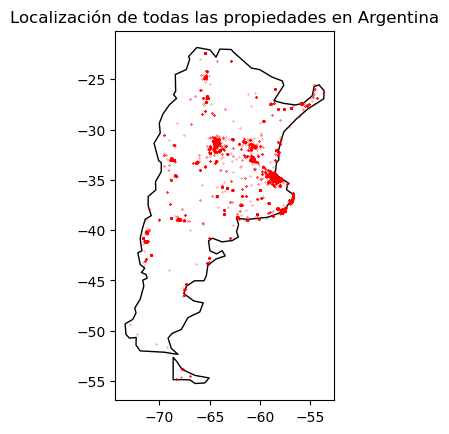

In [62]:
# Objetivo 1: Plot de todas las propiedades:

properatti_df_final_geografia = properatti_df[['title','place_with_parent_names','provincia','ciudad','barrio','partido','geometry']]
# Mapa de Argentina
ax = mapa_argentina_2.plot(color='white', edgecolor='black')

# Sobre las ciudades superpone el mapa del país
properatti_df.plot(ax=ax, color='red', markersize=0.05)

plt.title('Localización de todas las propiedades en Argentina')
plt.show()

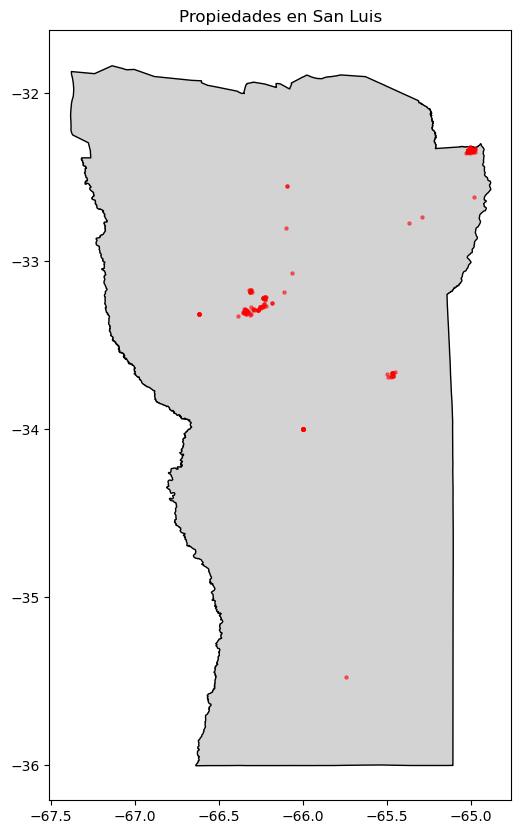

In [63]:
# Objetivo 1.1: Plot por provincia. En este caso, (ej.) San Luis.

mapa_san_luis = mapa_argentina[mapa_argentina.fna == "Provincia de San Luis"]

  # Para plotear, filtro los puntos que estan dentro de 'mapa_san_luis'

contained_points = properatti_df[properatti_df.geometry.within(mapa_san_luis.unary_union)]

# plot del mapa_san_luis
ax = mapa_san_luis.plot(figsize=(10, 10), color='lightgray', edgecolor='black')
contained_points.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5)
plt.title('Propiedades en San Luis')
plt.show()

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/1275857656.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=precios_barrios, x='barrio', y='price', palette='Set3')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


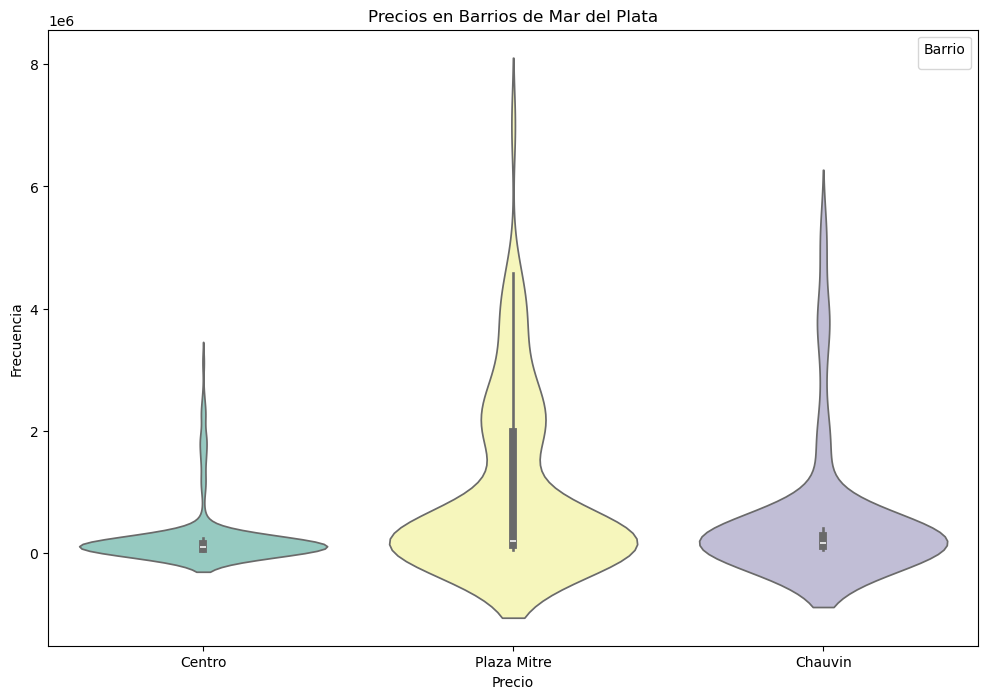

In [64]:
properatti_df[properatti_df['ciudad'] == 'Mar del Plata']['barrio'].value_counts()

# Barrios específicos en Mar del Plata
barrios = ['Centro', 'Plaza Mitre', 'Chauvin']

# Filtra el DataFrame original para incluir solo las propiedades de esos barrios en Mar del Plata
precios_barrios = properatti_df[(properatti_df['ciudad'] == 'Mar del Plata') & (properatti_df['barrio'].isin(barrios))]

plt.figure(figsize=(12, 8))
sns.violinplot(data=precios_barrios, x='barrio', y='price', palette='Set3')

plt.title('Precios en Barrios de Mar del Plata')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.legend(title='Barrio')
plt.show()

In [65]:
properatti_df[properatti_df['ciudad'] == 'Cordoba']['price_per_m2'].isnull().value_counts()


price_per_m2
False    3309
True     3200
Name: count, dtype: int64

In [66]:
properatti_df[properatti_df['ciudad'] == 'Tigre'].shape

(8940, 29)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/3716194373.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='barrio', y='price', data=precios_barrios, palette='Set3')


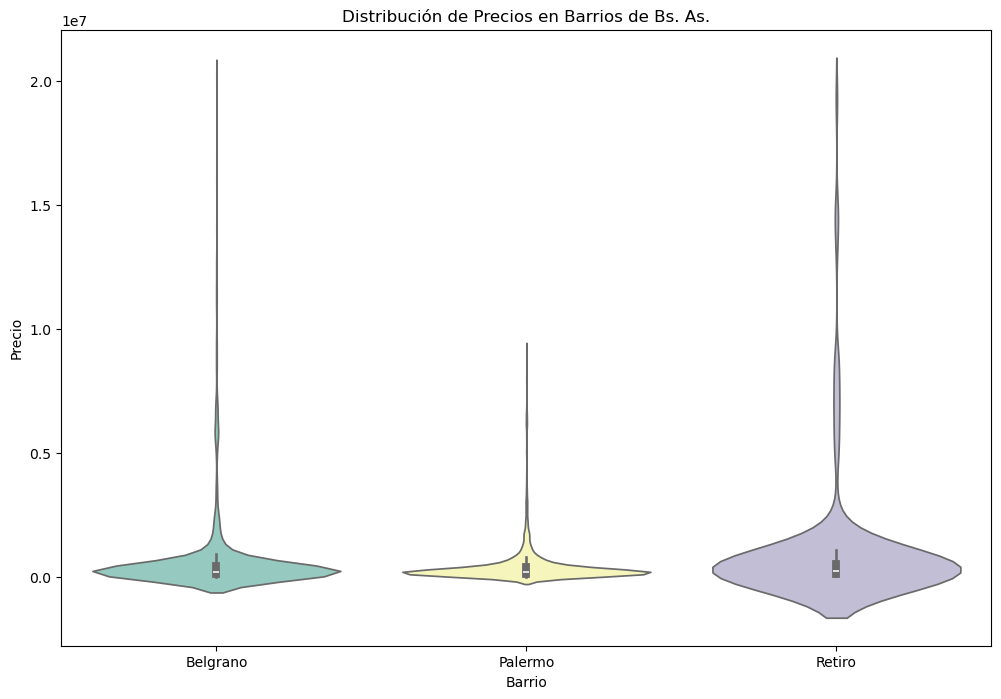

In [67]:
# Objetivo 2: Histograma de precios en tres barrios: Palermo, Nordelta y Centro de Mar del Plata.

barrios = ['Palermo', 'Belgrano', 'Retiro']

precios_barrios = properatti_df[properatti_df['barrio'].isin(barrios)]

plt.figure(figsize=(12, 8))
sns.violinplot(x='barrio', y='price', data=precios_barrios, palette='Set3')

plt.title('Distribución de Precios en Barrios de Bs. As.')
plt.xlabel('Barrio')
plt.ylabel('Precio')
plt.show()






#Limpieza de la columna "surface_total_in_m2"

In [68]:
#cuento las cantidad de valores nulos de la columa superficie total
df_surface_total = properatti_df['surface_total_in_m2']
print('Nulos en Surface Total:', df_surface_total.isnull().sum())

#calculo el porcentaje de nulos en Superficie Total
print('Procentaje de nulos en Surface Total:', (df_surface_total.isnull().sum()/ properatti_df.shape[0]))

Nulos en Surface Total: 38917
Procentaje de nulos en Surface Total: 0.32455986723043695


In [69]:
# separlo las columnas en las que se buscará la información faltante
df_description = properatti_df['description']
df_title = properatti_df['title']
df_url = properatti_df['properati_url']

In [70]:
#me fijo cuantos valores nulos hay en las columnas donde se buscará la información
print('Nulos en Description:', df_description.isnull().sum())

print('Nulos en Title:', df_title.isnull().sum())

print('Nulos en Url:', df_url.isnull().sum())

Nulos en Description: 2
Nulos en Title: 0
Nulos en Url: 0


In [71]:
#busco una regex para ver en que descripción/title/url hablan de superficie

surface_pattern = r"(\d+(?:,\d{1,2})?)\s*(m²|metros|m2|metros)"

regex = re.compile(surface_pattern, re.IGNORECASE)

In [72]:
#busco una descripción que hable de metros cuadrados para probar la regex

print(df_description.iloc[15])

ultima unidad disponiblehaus boulevard: metros cubiertos: 115,23m²contado u$d250.000haus village es un complejo residencial de 20 casas con cochera y jardín propio, dentro del barrio cerrado buenos aires village.todas las unidades tienen entrada para auto, en planta baja cuentan con un toilette, living comedor con cocina separada.patio exclusivo y, en planta alta, 3 dormitorios con espacio para placard (uno en suite).realizados en una estructura monolítica de hormigón armado sobre platea de fundación y aberturas de pvc con dvh. la calidad de la construcción conjuga lo moderno y lo funcional, con un cuidado especial por lo estético. son amplias superficies vidriadas que permiten vivir el verde del jardín en todo momento. el barrio cerrado cuenta con una doble entrada, lo que permite una mejor circulación interna de vehículos. ofrece excelentes alternativas para los accesos al barrio, una entrada es por la autopista del buen ayre y la otra por la calle flaubert. easybroker id: eb-an8955


In [73]:
# pruebo si la regex funciona en una descrpción en la que se que hablan de m2

print(regex.search(df_description.iloc[15]))

<re.Match object; span=(58, 66), match='115,23m²'>


In [74]:
#pruebo la regex en un texto generado por mi
texto = 'dakfj jdhf urhfsdfh jhdfa fp 245 metros cuadrados djdfhsjkdhf'

prueba = re.findall(surface_pattern, texto)

print(prueba)

[('245', 'metros')]


In [75]:
#filtro el data frame
df_filtrado = properatti_df[(properatti_df['surface_total_in_m2'].isnull())]

#veo el tamaño del dataframe filtrado
print(df_filtrado.shape)

(38917, 29)


In [76]:
#filtro el dataframe donde la regex encuantra valores y el cuantas encontró
df_filtrado_2 = df_filtrado[
    df_filtrado["description"].str.contains(surface_pattern) |
    df_filtrado["title"].str.contains(surface_pattern) |
    df_filtrado["properati_url"].str.contains(surface_pattern)
]

print(df_filtrado_2.shape)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2891084609.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtrado["description"].str.contains(surface_pattern) |


(9911, 29)


/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2891084609.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtrado["title"].str.contains(surface_pattern) |
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2891084609.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtrado["properati_url"].str.contains(surface_pattern)


In [77]:
#defino una función para aplicar la regex
def extract_largest_value(text, regex_pattern):
    matches = re.findall(regex_pattern, text)

    if matches:
        valores_numericos = [float(match[0].replace(',', '.')) for match in matches]
        max_valor = max(valores_numericos)
        return str(max_valor)
    else:
        return ""

In [78]:
#agrego 3 columnas con los valores encontrados por la regex
print(df_filtrado_2.shape)
df_filtrado_2.loc[:, 'description_short'] = df_filtrado_2['description'].apply(lambda x: extract_largest_value(x, surface_pattern))
df_filtrado_2.loc[:, 'title_short'] = df_filtrado_2['title'].apply(lambda x: extract_largest_value(x, surface_pattern))
df_filtrado_2.loc[:, 'url_short'] = df_filtrado_2['properati_url'].apply(lambda x: extract_largest_value(x, surface_pattern))
print(df_filtrado_2.shape)
print(df_filtrado_2["description_short"])
print(df_filtrado_2["title_short"])

(9911, 29)
(9911, 32)
65         50.0
77             
79             
109        60.0
111        90.0
          ...  
121134    124.0
121155    550.0
121156    550.0
121207    210.0
121208    210.0
Name: description_short, Length: 9911, dtype: object
65            
77        85.0
79        42.0
109           
111           
          ... 
121134        
121155        
121156        
121207        
121208        
Name: title_short, Length: 9911, dtype: object


/Users/juanvassallo/anaconda3/envs/dhdsblend2021_geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/juanvassallo/anaconda3/envs/dhdsblend2021_geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/juanvassallo/anaconda3/envs/dhdsblend2021_geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:1543:

In [79]:
#defino una función para aplicar otra regex y solo quedamre con los valores numerícos eliminando los m2, metros o metros cuadrados
def extract_number_from_string(string):
    match = re.search(r'(\d+(\.\d+)?)', str(string))
    return float(match.group(1)) if match else pd.NA

#defino una función para juntar los valores obtenidos con los originales del data frame
def fill_null(row):
    if pd.isnull(row['surface_total_in_m2']):
        corresponding_value = df_filtrado_2.loc[df_filtrado_2['index_column'] == row['index_column'], 'description_short'].values
        if len(corresponding_value) > 0:
            return extract_number_from_string(corresponding_value[0])
    return row['surface_total_in_m2']

#Agrego una columna de índice común a ambos DataFrames para machear filas
properatti_df['index_column'] = properatti_df.index
df_filtrado_2['index_column'] = df_filtrado_2.index

#aplico la función y creo la columna 'surface_covered_clean' con los valores
properatti_df['surface_total_clean'] = properatti_df.apply(fill_null, axis=1)

#elimino la columna de índice temporal
properatti_df.drop('index_column', axis=1, inplace=True)
df_filtrado_2.drop('index_column', axis=1, inplace=True)

/Users/juanvassallo/anaconda3/envs/dhdsblend2021_geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/919461477.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado_2.drop('index_column', axis=1, inplace=True)


In [80]:
#veo cuantos nulos quedaron en la nueva columna y comparo con la irginal

print('Nulos en la Surface_clean:', properatti_df['surface_total_clean'].isnull().sum())
print('Nulos en Surface original', properatti_df['surface_total_in_m2'].isnull().sum())
print('Cantidad de valores agregados:',properatti_df['surface_total_in_m2'].isnull().sum() - properatti_df['surface_total_clean'].isnull().sum())

Nulos en la Surface_clean: 29279
Nulos en Surface original 38917
Cantidad de valores agregados: 9638


In [81]:
#calculo la media de las superficies
properatti_df['surface_total_clean'].mean()

336.2083309793882

# Limpieza de la columna "price"

In [82]:
#Selecciono las columnas relacionadas con precio como currency, precio, precio aprox usd etc#

precios=properatti_df.loc[:,["price","currency","price_aprox_local_currency","price_aprox_usd","price_usd_per_m2","price_per_m2"]]
precios

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2
0,62000.0,USD,1093959.00,62000.0,1127.272727,1550.000000
1,150000.0,USD,2646675.00,150000.0,NaN,NaN
2,72000.0,USD,1270404.00,72000.0,1309.090909,1309.090909
3,95000.0,USD,1676227.50,95000.0,NaN,NaN
4,64000.0,USD,1129248.00,64000.0,1828.571429,1828.571429
...,...,...,...,...,...,...
121215,870000.0,USD,15350715.00,870000.0,7699.115044,9354.838710
121216,498000.0,USD,8786961.00,498000.0,1383.333333,1383.333333
121217,131500.0,USD,2320251.75,131500.0,2858.695652,3371.794872
121218,95900.0,USD,1692107.55,95900.0,1997.916667,1997.916667


In [83]:
precios['Index'] = range(1, len(precios)+1)
precios["Index"]

0              1
1              2
2              3
3              4
4              5
           ...  
121215    119903
121216    119904
121217    119905
121218    119906
121219    119907
Name: Index, Length: 119907, dtype: int64

In [84]:
#Calculo cantidad de nulos en precio. siguiente 3 comandos#

nulos=pd.isnull(properatti_df["price"]).sum()
nulos

20149

In [85]:
porcentaje_nulos=nulos/(properatti_df["price"].shape[0])*100

In [86]:
porcentaje_nulos

16.80385632198287

In [87]:
nulos.dtype

is_notnull_result = precios.notnull()
canti_not_null=is_notnull_result.sum()
print(canti_not_null)


price                          99758
currency                       99757
price_aprox_local_currency     99758
price_aprox_usd                99758
price_usd_per_m2               67861
price_per_m2                   86774
Index                         119907
dtype: int64


In [88]:
porcentaje_no_nulos=canti_not_null/(properatti_df.shape[0])*100

In [89]:
porcentaje_no_nulos

price                          83.196144
currency                       83.195310
price_aprox_local_currency     83.196144
price_aprox_usd                83.196144
price_usd_per_m2               56.594694
price_per_m2                   72.367752
Index                         100.000000
dtype: float64

In [90]:
precios.dtypes

price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
price_usd_per_m2              float64
price_per_m2                  float64
Index                           int64
dtype: object

In [91]:
#corroborar que hay nulos en precios#
precios["price"].head(10)

0     62000.0
1    150000.0
2     72000.0
3     95000.0
4     64000.0
5         NaN
6    130000.0
7    138000.0
8    195000.0
9    460000.0
Name: price, dtype: float64

In [92]:
#contar cantidad de nulos#
contar_valores=properatti_df["price"].value_counts(dropna=False)
contar_valores

price
NaN          20149
120000.0      1655
130000.0      1453
150000.0      1395
110000.0      1323
             ...  
292100.0         1
1467000.0        1
1356000.0        1
232837.0         1
1036300.0        1
Name: count, Length: 9595, dtype: int64

In [93]:
#Tipos de monedas que componen el campo currency#

In [94]:
df_currency_type = properatti_df.groupby("currency")

In [95]:
df_currency_type_values = list(df_currency_type.groups.keys())
df_currency_type_values

['ARS', 'PEN', 'USD', 'UYU']

In [96]:
#Cantidad de entries con cada campo#

precio_por_moneda=properatti_df.groupby("currency")["price"].count()
precio_por_moneda

currency
ARS    12910
PEN        2
USD    86844
UYU        1
Name: price, dtype: int64

In [97]:
mascara_uyu=precios["currency"]=="UYU"
fila_uy=precios[mascara_uyu]
fila_uy

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2,Index
107390,650000000.0,UYU,4.054773e+08,22980378.29,NaN,NaN,106216


In [98]:
mascara_pen=precios["currency"]=="PEN"
fila_pen=precios[mascara_pen]
fila_pen

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2,Index
50387,380000.0,PEN,2066864.90,117139.33,NaN,NaN,49718
50388,950000.0,PEN,5167162.35,292848.33,NaN,NaN,49719


In [99]:
valores=properatti_df[mascara_uyu]
pd.set_option("display.max_colwidth",1000)
print(valores["description"])
print(valores["properati_url"])
print(valores["title"])

107390    casa con calefacción central, mendoza, san roque, por $ 650.000.000
Name: description, dtype: object
107390    http://www.properati.com.ar/1by0s_venta_casa_san-roque_garage_ciudad-inmobiliaria_go2
Name: properati_url, dtype: object
107390    casa - san vicente
Name: title, dtype: object


In [100]:
valor_pesos=precios[mascara_uyu]
valor_pesos

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2,Index
107390,650000000.0,UYU,4.054773e+08,22980378.29,NaN,NaN,106216


In [101]:
#Filtramos los datos de descripcion por moneda#

import re

In [102]:
data_filtrada = properatti_df[properatti_df['price'].isnull()]
regex_pattern_2 = re.compile(r'\b(?:usd|us\$|u\$s|\$|ars)\b', re.IGNORECASE)
filtered_df_2 = data_filtrada[
    data_filtrada["description"].str.contains(regex_pattern_2) |
    data_filtrada["title"].str.contains(regex_pattern_2) |
    data_filtrada["properati_url"].str.contains(regex_pattern_2)
]

print(filtered_df_2.shape)

(3667, 30)


hay 3695 lineas filtradas que corresponden a valores de precio nulos y que se pueden rellenar
#

In [103]:
# Define a function to extract substrings around the regex pattern
def extract_substring(text, regex_pattern):
    match = re.search(regex_pattern, text)
    if match:
        start_index = max(0, match.start() - 5)
        end_index = match.end() + 10
        return text[start_index:end_index]
    else:
        return ""



# Use .loc to set values in the DataFrame
print(filtered_df_2.shape)
filtered_df_2.loc[:, 'description_short'] = filtered_df_2['description'].apply(lambda x: extract_substring(x, regex_pattern_2))
filtered_df_2.loc[:, 'title_short'] = filtered_df_2['title'].apply(lambda x: extract_substring(x, regex_pattern_2))
filtered_df_2.loc[:, 'url_short'] = filtered_df_2['properati_url'].apply(lambda x: extract_substring(x, regex_pattern_2))
print(filtered_df_2.shape)
print(filtered_df_2["description"])
print(*filtered_df_2["title_short"])



(3667, 30)
(3667, 33)
124                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        codigo: 2366-347 ubicado en: puerto roldan -  publicado por: cosa propiedades. el precio es de ars 1 null. 3 dormitorios 125 m2 cubiertos + 54 m2 semicubiertos terreno 1115 m2 (26x43) todo en una planta 2 baños completos living comedor con cocina semi integrada .

/Users/juanvassallo/anaconda3/envs/dhdsblend2021_geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/juanvassallo/anaconda3/envs/dhdsblend2021_geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/juanvassallo/anaconda3/envs/dhdsblend2021_geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:1543:

In [104]:
filtered_df_2.dtypes

property_type                   object
place_name                      object
place_with_parent_names         object
country_name                    object
state_name                      object
geonames_id                    float64
lat-lon                         object
lat                            float64
lon                            float64
price                          float64
currency                        object
price_aprox_local_currency     float64
price_aprox_usd                float64
surface_total_in_m2            float64
surface_covered_in_m2          float64
price_usd_per_m2               float64
price_per_m2                   float64
floor                          float64
rooms                          float64
expenses                       float64
properati_url                   object
description                     object
title                           object
image_thumbnail                 object
provincia                       object
ciudad                   

In [105]:
#Luego de filtrados los datos por moneda, los filtramos por moneda de vuelta, por . y por cantidad de 5 digitos o màs (para descartar que se pusieran datos que correspondan a expensas u otras cosas )

pattern_regex="U\$S\s|usd|us\$*"
dolar_regex=re.compile(pattern_regex)
decimal_regex="\."
compile_decimal=re.compile(decimal_regex)

sin_dolar = filtered_df_2.description_short.apply(lambda x: x if x is np.NaN else dolar_regex.sub("", x))
sin_dolar.head(10)
sin_punto=sin_dolar.apply(lambda x: x if x is np.NaN else compile_decimal.sub("", x))
sin_punto.head(10)

pattern_numero=r'(\d{5,})'
regex_numero=re.compile(pattern_numero)
cinco_digitos=sin_punto.str.extract(pattern_numero).astype(float)
print(cinco_digitos)
cinco_digitos.isnull().count()


              0
124         NaN
125         NaN
126         NaN
263         NaN
273         NaN
...         ...
120911  20000.0
120912  20000.0
120913  20000.0
120914  20000.0
121214      NaN

[3667 rows x 1 columns]


0    3667
dtype: int64

In [106]:
#En base a los anteriores filtrados y a descartar la cantidad de entries que no cumplen con el campo quedan 580 entries en descripcion que permiten llenar el campo precio#

In [107]:
nulos_descripcion=cinco_digitos.dropna()

In [108]:
print(nulos_descripcion.count())


0    572
dtype: int64


In [109]:
precios["price_clean"]=precios["price"].copy()

In [110]:
precios["price_clean"].head(19)

0      62000.0
1     150000.0
2      72000.0
3      95000.0
4      64000.0
5          NaN
6     130000.0
7     138000.0
8     195000.0
9     460000.0
10     70000.0
11    150000.0
12    115000.0
13    111700.0
14    147900.0
15    250000.0
16    239000.0
17    315000.0
18    570000.0
Name: price_clean, dtype: float64

In [111]:
print(nulos_descripcion[0])

1413       11111.0
1665      260000.0
1666      115000.0
1677      115000.0
1690      110000.0
            ...   
120910     20000.0
120911     20000.0
120912     20000.0
120913     20000.0
120914     20000.0
Name: 0, Length: 572, dtype: float64


In [112]:
precios['Clean_precios'] = precios["price_clean"].fillna(nulos_descripcion.iloc[:,0])

In [113]:
precios["Clean_precios"]

0          62000.0
1         150000.0
2          72000.0
3          95000.0
4          64000.0
            ...   
121215    870000.0
121216    498000.0
121217    131500.0
121218     95900.0
121219    129000.0
Name: Clean_precios, Length: 119907, dtype: float64

In [114]:
nulos_descripcion.iloc[:,0]

1413       11111.0
1665      260000.0
1666      115000.0
1677      115000.0
1690      110000.0
            ...   
120910     20000.0
120911     20000.0
120912     20000.0
120913     20000.0
120914     20000.0
Name: 0, Length: 572, dtype: float64

In [115]:
pattern_regex="U\$S\s|usd|us\$*"
dolar_regex=re.compile(pattern_regex)
decimal_regex="\."
compile_decimal=re.compile(decimal_regex)

sin_dolar = filtered_df_2.title_short.apply(lambda x: x if x is np.NaN else dolar_regex.sub("", x))
sin_dolar.head(10)
sin_punto=sin_dolar.apply(lambda x: x if x is np.NaN else compile_decimal.sub("", x))
sin_punto.head(10)

pattern_numero=r'(\d{5,})'
regex_numero=re.compile(pattern_numero)
cinco_digitos_ti=sin_punto.str.extract(pattern_numero).astype(float)
print(cinco_digitos_ti)
cinco_digitos_ti.isnull().count()

         0
124    NaN
125    NaN
126    NaN
263    NaN
273    NaN
...     ..
120911 NaN
120912 NaN
120913 NaN
120914 NaN
121214 NaN

[3667 rows x 1 columns]


0    3667
dtype: int64

In [116]:
#Se hizo el mismo protocolo para el titulo (el ti de los comandos hace referencia a eso) se encontraron 2412 campos que permitirian llenar#

In [117]:
nulos_descripcion_ti=cinco_digitos_ti.dropna()
nulos_descripcion_ti.count()

0    2411
dtype: int64

In [118]:
precios['Clean_precio_titulo'] = precios["Clean_precios"].fillna(nulos_descripcion_ti.iloc[:,0])

In [119]:
precios["Clean_precio_titulo"].isnull().sum()

17413

In [120]:
#mismo protocolo para el caso de la URL. se encontraron 0 campos que permite llenar#

sin_dolar = filtered_df_2.url_short.apply(lambda x: x if x is np.NaN else dolar_regex.sub("", x))
sin_dolar.head(10)
sin_punto=sin_dolar.apply(lambda x: x if x is np.NaN else compile_decimal.sub("", x))
sin_punto.head(10)

pattern_numero=r'(\d{5,})'
regex_numero=re.compile(pattern_numero)
cinco_digitos_url=sin_punto.str.extract(pattern_numero).astype(float)
print(cinco_digitos_url)
cinco_digitos_url.isnull().count()
nulos_descripcion_url=cinco_digitos_url.dropna()
nulos_descripcion_url.count()

         0
124    NaN
125    NaN
126    NaN
263    NaN
273    NaN
...     ..
120911 NaN
120912 NaN
120913 NaN
120914 NaN
121214 NaN

[3667 rows x 1 columns]


0    0
dtype: int64

para hacer lo anterior hago una mascara con currency ars

In [121]:
mascara_ars=precios["currency"]=="ARS"
entries_en_ARS=precios[mascara_ars]
entries_en_ARS.head(10)

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2,Index,price_clean,Clean_precios,Clean_precio_titulo
9,460000.0,ARS,455201.45,25798.49,NaN,NaN,10,460000.0,460000.0,460000.0
32,550000.0,ARS,544262.59,30846.02,616.920400,11000.000000,33,550000.0,550000.0,550000.0
37,1250000.0,ARS,1236960.43,70104.59,934.727867,16666.666667,38,1250000.0,1250000.0,1250000.0
78,5500000.0,ARS,5442626.35,308460.22,1181.839923,295.460650,78,5500000.0,5500000.0,5500000.0
97,1423800.0,ARS,1408947.37,79851.93,NaN,NaN,97,1423800.0,1423800.0,1423800.0
99,850000.0,ARS,841133.07,47671.12,238.355600,4722.222222,99,850000.0,850000.0,850000.0
122,2600000.0,ARS,2572877.76,145817.55,423.888227,13829.787234,121,2600000.0,2600000.0,2600000.0
128,1250000.0,ARS,1236960.43,70104.59,543.446434,18939.393939,127,1250000.0,1250000.0,1250000.0
154,1200000.0,ARS,1187482.08,67300.41,NaN,30000.000000,152,1200000.0,1200000.0,1200000.0
168,2500000.0,ARS,2473921.05,140209.19,719.021487,NaN,166,2500000.0,2500000.0,2500000.0


In [122]:
precios["conversion_en_USD"]=entries_en_ARS["price_aprox_local_currency"]/entries_en_ARS["price_aprox_usd"]

In [123]:
precios["conversion_en_USD"].head(10)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9    17.6445
Name: conversion_en_USD, dtype: float64

In [124]:
descarto_nulos_conversion_USD=precios["conversion_en_USD"].dropna()

In [125]:
descarto_nulos_conversion_USD.head(10)

9      17.6445
32     17.6445
37     17.6445
78     17.6445
97     17.6445
99     17.6445
122    17.6445
128    17.6445
154    17.6445
168    17.6445
Name: conversion_en_USD, dtype: float64

In [126]:
descarto_nulos_conversion_USD.mean()

17.644499924849544

In [127]:
#De acuerdo con este promedio 1 dolar corresponde a 17,6445 pesos Se podrìa comprobar lo mismo con las entradas correspondientes al campo currency USD

In [128]:
mascara_usd=precios["currency"]=="USD"
entries_en_usd=precios[mascara_usd]
entries_en_usd.head(10)



,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2,Index,price_clean,Clean_precios,Clean_precio_titulo,conversion_en_USD
0,62000.0,USD,1093959.0,62000.0,1127.272727,1550.000000,1,62000.0,62000.0,62000.0,NaN
1,150000.0,USD,2646675.0,150000.0,NaN,NaN,2,150000.0,150000.0,150000.0,NaN
2,72000.0,USD,1270404.0,72000.0,1309.090909,1309.090909,3,72000.0,72000.0,72000.0,NaN
3,95000.0,USD,1676227.5,95000.0,NaN,NaN,4,95000.0,95000.0,95000.0,NaN
4,64000.0,USD,1129248.0,64000.0,1828.571429,1828.571429,5,64000.0,64000.0,64000.0,NaN
6,130000.0,USD,2293785.0,130000.0,1226.415094,1666.666667,7,130000.0,130000.0,130000.0,NaN
7,138000.0,USD,2434941.0,138000.0,3066.666667,3450.000000,8,138000.0,138000.0,138000.0,NaN
8,195000.0,USD,3440677.5,195000.0,3000.000000,3250.000000,9,195000.0,195000.0,195000.0,NaN
10,70000.0,USD,1235115.0,70000.0,46.235139,NaN,11,70000.0,70000.0,70000.0,NaN
11,150000.0,USD,2646675.0,150000.0,NaN,NaN,12,150000.0,150000.0,150000.0,NaN


In [129]:
precios["conversion_en_USD_currency_USD"]=entries_en_usd["price_aprox_local_currency"]/entries_en_usd["price_aprox_usd"]

In [130]:
descarto_nulos_conversion_USD_currency_USD=precios["conversion_en_USD_currency_USD"].dropna()

In [131]:
descarto_nulos_conversion_USD_currency_USD.head(10)

0     17.6445
1     17.6445
2     17.6445
3     17.6445
4     17.6445
6     17.6445
7     17.6445
8     17.6445
10    17.6445
11    17.6445
Name: conversion_en_USD_currency_USD, dtype: float64

In [132]:
descarto_nulos_conversion_USD_currency_USD.mean()

17.644499998125596

In [133]:
#De acuerdo con este promedio 1 dolar corresponde a 17,6445 pesos

#Valor con las entradas correspondientes al campo currency USD
#Se pueden normalizar los entries por ese valor de pesos

In [134]:
#conversion de los campos del dataframe PRecios que tiene como moneda ARS a USD
#a la vez se corrigen los valores de ARS#

In [135]:
precios.loc[mascara_ars,"Clean_precio_titulo"]/=(descarto_nulos_conversion_USD.mean())

In [136]:
precios[mascara_ars]

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2,Index,price_clean,Clean_precios,Clean_precio_titulo,conversion_en_USD,conversion_en_USD_currency_USD
9,460000.0,ARS,455201.45,25798.49,NaN,NaN,10,460000.0,460000.0,26070.446993,17.6445,NaN
32,550000.0,ARS,544262.59,30846.02,616.920400,11000.000000,33,550000.0,550000.0,31171.186621,17.6445,NaN
37,1250000.0,ARS,1236960.43,70104.59,934.727867,16666.666667,38,1250000.0,1250000.0,70843.605958,17.6445,NaN
78,5500000.0,ARS,5442626.35,308460.22,1181.839923,295.460650,78,5500000.0,5500000.0,311711.866215,17.6445,NaN
97,1423800.0,ARS,1408947.37,79851.93,NaN,NaN,97,1423800.0,1423800.0,80693.700930,17.6445,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
121202,1507000.0,ARS,1491279.61,84518.10,1625.348077,NaN,119890,1507000.0,1507000.0,85409.051343,17.6445,NaN
121203,1502000.0,ARS,1486331.74,84237.68,1684.753600,NaN,119891,1502000.0,1502000.0,85125.676919,17.6445,NaN
121204,1502000.0,ARS,1486331.74,84237.68,1684.753600,NaN,119892,1502000.0,1502000.0,85125.676919,17.6445,NaN
121205,1507000.0,ARS,1491279.61,84518.10,1690.362000,NaN,119893,1507000.0,1507000.0,85409.051343,17.6445,NaN


In [137]:
precios["currency_new"]=precios["currency"].replace("ARS","USD")

In [138]:
precios["currency_new"]

0         USD
1         USD
2         USD
3         USD
4         USD
         ... 
121215    USD
121216    USD
121217    USD
121218    USD
121219    USD
Name: currency_new, Length: 119907, dtype: object

In [139]:
precios = precios.rename(columns={'Clean_precio_titulo': 'precios_nuevos'})

In [140]:
precios.dtypes

price                             float64
currency                           object
price_aprox_local_currency        float64
price_aprox_usd                   float64
price_usd_per_m2                  float64
price_per_m2                      float64
Index                               int64
price_clean                       float64
Clean_precios                     float64
precios_nuevos                    float64
conversion_en_USD                 float64
conversion_en_USD_currency_USD    float64
currency_new                       object
dtype: object

Cambio todos los valores del campo currency_new a USD#

In [141]:
fill="USD"

In [142]:
precios['currency_new'] = precios.apply(lambda row: fill if pd.isna(row['currency_new']) and pd.notna(row['precios_nuevos']) else row['currency_new'], axis=1)

Por ùltimo tomo en cuenta los valores de los campos correspondientes a las sntradas de currency en UYU y en PEN
y las normalizo a USD

In [143]:
precios[mascara_uyu]

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2,Index,price_clean,Clean_precios,precios_nuevos,conversion_en_USD,conversion_en_USD_currency_USD,currency_new
107390,650000000.0,UYU,4.054773e+08,22980378.29,NaN,NaN,106216,650000000.0,650000000.0,650000000.0,NaN,NaN,UYU


In [144]:
fila_uy["price_aprox_local_currency"]/fila_uy["price_aprox_usd"]
masc_uyu=properatti_df["currency"]=="UYU"
properatti_df[masc_uyu]

,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,provincia,ciudad,barrio,partido,geometry,surface_total_clean
107390,house,San Roque,|Argentina|Mendoza|San Roque|,Argentina,Mendoza,3836586.0,NaN,-33.02887,-68.59729,650000000.0,UYU,4.054773e+08,22980378.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1by0s_venta_casa_san-roque_garage_ciudad-inmobiliaria_go2,"casa con calefacción central, mendoza, san roque, por $ 650.000.000",casa - san vicente,https://thumbs4.properati.com/2/pA0RbuDKRK6GgVfYNIGhuZABjmw=/trim/198x0/smart/filters:strip_icc()/tbcn.s3-accelerate.amazonaws.com/pictures/93074386646834267802048084061149412749606864096523041674189414770450190912595.jpg,Mendoza,San Roque,None,None,POINT (-68.59729 -33.02887),NaN


In [145]:
fila_uy["price_aprox_local_currency"]/fila_uy["price"]
fila_uy["price"]/fila_uy["price_aprox_usd"]

107390    28.285
dtype: float64

In [146]:
new_price_UYUtoUSD=fila_uy["price_aprox_usd"]
new_price_UYUtoUSD

107390    22980378.29
Name: price_aprox_usd, dtype: float64

In [147]:
precios["precios_nuevos"][107391]=new_price_UYUtoUSD

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2193192114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precios["precios_nuevos"][107391]=new_price_UYUtoUSD
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2193192114.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  precios["precios_nuevos"][107391]=new_price_UYUtoUSD


In [148]:
precios["precios_nuevos"][107391]

22980378.29

In [149]:
fila_pen

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2,Index
50387,380000.0,PEN,2066864.90,117139.33,NaN,NaN,49718
50388,950000.0,PEN,5167162.35,292848.33,NaN,NaN,49719


In [150]:
fila_pen["price"]/fila_pen["price_aprox_usd"]

50387    3.244
50388    3.244
dtype: float64

In [151]:
fila_pen["price_aprox_local_currency"]/fila_pen["price_aprox_usd"]

50387    17.6445
50388    17.6445
dtype: float64

In [152]:
new_price_PENtoUSD=fila_pen["price_aprox_usd"]

In [153]:
precios.loc[mascara_pen,"precios_nuevos"]=new_price_PENtoUSD

In [154]:
precios['currency_new'].replace("PEN","USD")
precios["currency_new"].replace("UYU","USD")
precios["currency_new"]

0         USD
1         USD
2         USD
3         USD
4         USD
         ... 
121215    USD
121216    USD
121217    USD
121218    USD
121219    USD
Name: currency_new, Length: 119907, dtype: object

Luego de seleccionadas las columnas correpsondeintes a price aprox en USD para los casos de pesos UYU y de PEN se
unificaron los currency en la columna currency para establecer su normalizacion a USD

In [155]:
precios.dtypes

price                             float64
currency                           object
price_aprox_local_currency        float64
price_aprox_usd                   float64
price_usd_per_m2                  float64
price_per_m2                      float64
Index                               int64
price_clean                       float64
Clean_precios                     float64
precios_nuevos                    float64
conversion_en_USD                 float64
conversion_en_USD_currency_USD    float64
currency_new                       object
dtype: object

In [156]:
precios=precios.drop(labels=["price_clean", "Clean_precios", "conversion_en_USD", "conversion_en_USD_currency_USD"], axis=1)

In [157]:
precios

,price,currency,price_aprox_local_currency,price_aprox_usd,price_usd_per_m2,price_per_m2,Index,precios_nuevos,currency_new
0,62000.0,USD,1093959.00,62000.0,1127.272727,1550.000000,1,62000.0,USD
1,150000.0,USD,2646675.00,150000.0,NaN,NaN,2,150000.0,USD
2,72000.0,USD,1270404.00,72000.0,1309.090909,1309.090909,3,72000.0,USD
3,95000.0,USD,1676227.50,95000.0,NaN,NaN,4,95000.0,USD
4,64000.0,USD,1129248.00,64000.0,1828.571429,1828.571429,5,64000.0,USD
...,...,...,...,...,...,...,...,...,...
121215,870000.0,USD,15350715.00,870000.0,7699.115044,9354.838710,119903,870000.0,USD
121216,498000.0,USD,8786961.00,498000.0,1383.333333,1383.333333,119904,498000.0,USD
121217,131500.0,USD,2320251.75,131500.0,2858.695652,3371.794872,119905,131500.0,USD
121218,95900.0,USD,1692107.55,95900.0,1997.916667,1997.916667,119906,95900.0,USD


In [158]:
print("nulos en la columna precios nueva :", precios['precios_nuevos'].isnull().sum())
print("nulos en la columna precios inicial:", precios['price'].isnull().sum())

nulos en la columna precios nueva : 17413
nulos en la columna precios inicial: 20149


# Gráficos de porcentajes de nulos en cada columna

In [159]:
for col in properatti_df.columns:
    print(col)

property_type
place_name
place_with_parent_names
country_name
state_name
geonames_id
lat-lon
lat
lon
price
currency
price_aprox_local_currency
price_aprox_usd
surface_total_in_m2
surface_covered_in_m2
price_usd_per_m2
price_per_m2
floor
rooms
expenses
properati_url
description
title
image_thumbnail
provincia
ciudad
barrio
partido
geometry
surface_total_clean


In [160]:
properatti_df.dtypes

property_type                   object
place_name                      object
place_with_parent_names         object
country_name                    object
state_name                      object
geonames_id                    float64
lat-lon                         object
lat                            float64
lon                            float64
price                          float64
currency                        object
price_aprox_local_currency     float64
price_aprox_usd                float64
surface_total_in_m2            float64
surface_covered_in_m2          float64
price_usd_per_m2               float64
price_per_m2                   float64
floor                          float64
rooms                          float64
expenses                       float64
properati_url                   object
description                     object
title                           object
image_thumbnail                 object
provincia                       object
ciudad                   

In [161]:
numero_de_nulos=properatti_df.isna().sum()

In [162]:
properatti_df.shape[0]

119907

In [163]:
porcentaje_de_nulos=numero_de_nulos/(properatti_df.shape[0])*100

In [164]:
nulos_redondeados=porcentaje_de_nulos.round(2)

In [165]:
nulos_redondeados

property_type                  0.00
place_name                     0.02
place_with_parent_names        0.00
country_name                   0.00
state_name                     0.00
geonames_id                   15.54
lat-lon                       42.68
lat                            0.00
lon                            0.00
price                         16.80
currency                      16.80
price_aprox_local_currency    16.80
price_aprox_usd               16.80
surface_total_in_m2           32.46
surface_covered_in_m2         16.35
price_usd_per_m2              43.41
price_per_m2                  27.63
floor                         93.43
rooms                         61.01
expenses                      88.16
properati_url                  0.00
description                    0.00
title                          0.00
image_thumbnail                2.58
provincia                      0.00
ciudad                         2.86
barrio                        41.97
partido                     

In [166]:
lista=properatti_df.columns.tolist()

In [167]:
lista[0]

'property_type'

In [168]:
valores=nulos_redondeados.tolist()

In [169]:
valores

[0.0,
 0.02,
 0.0,
 0.0,
 0.0,
 15.54,
 42.68,
 0.0,
 0.0,
 16.8,
 16.8,
 16.8,
 16.8,
 32.46,
 16.35,
 43.41,
 27.63,
 93.43,
 61.01,
 88.16,
 0.0,
 0.0,
 0.0,
 2.58,
 0.0,
 2.86,
 41.97,
 49.44,
 0.0,
 24.42]

In [170]:
print(len(lista))
print(len(valores))

30
30


In [171]:
lista1=lista[0:8]
print(lista1)
lista2=lista[8:17]
print(lista2)
lista3=lista[17:]
print(lista3)

['property_type', 'place_name', 'place_with_parent_names', 'country_name', 'state_name', 'geonames_id', 'lat-lon', 'lat']
['lon', 'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2']
['floor', 'rooms', 'expenses', 'properati_url', 'description', 'title', 'image_thumbnail', 'provincia', 'ciudad', 'barrio', 'partido', 'geometry', 'surface_total_clean']


In [172]:
valores1=valores[0:8]
print(valores1)
valores2=valores[8:17]
print(valores2)
valores3=valores[17:]
print(valores3)

[0.0, 0.02, 0.0, 0.0, 0.0, 15.54, 42.68, 0.0]
[0.0, 16.8, 16.8, 16.8, 16.8, 32.46, 16.35, 43.41, 27.63]
[93.43, 61.01, 88.16, 0.0, 0.0, 0.0, 2.58, 0.0, 2.86, 41.97, 49.44, 0.0, 24.42]


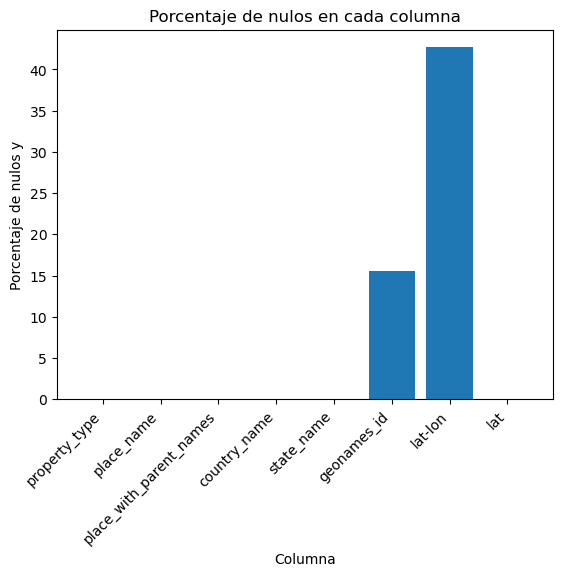

In [173]:
fig, ax = plt.subplots()

ax.bar(lista1, valores1, tick_label= lista1)

ax.set(xlabel = "Columna", ylabel = "Porcentaje de nulos y", title = "Porcentaje de nulos en cada columna")
plt.xticks(rotation=45, ha="right")
plt.show()


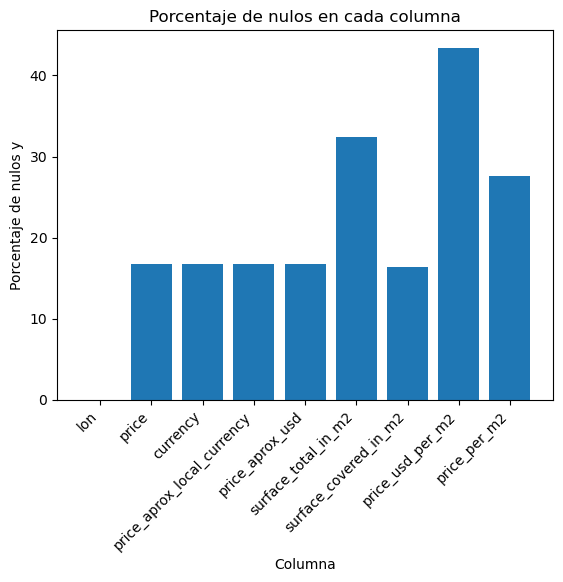

In [174]:
fig2, ax2 = plt.subplots()

ax2.bar(lista2, valores2, tick_label= lista2)

ax2.set(xlabel = "Columna", ylabel = "Porcentaje de nulos y", title = "Porcentaje de nulos en cada columna")
plt.xticks(rotation=45, ha="right")
plt.show()


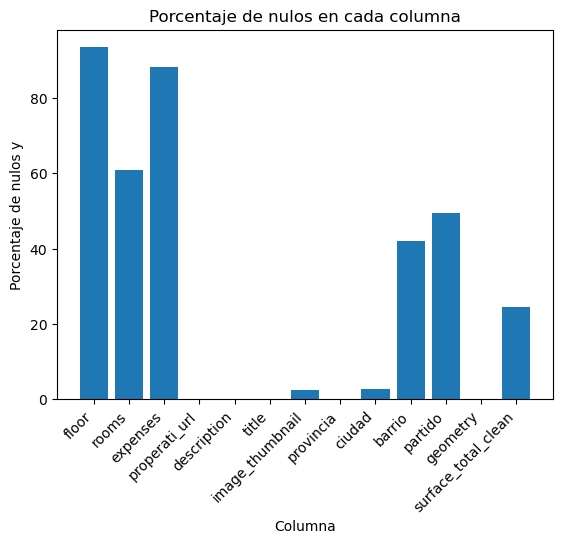

In [175]:
fig3, ax3 = plt.subplots()

ax3.bar(lista3, valores3, tick_label= lista3)

ax3.set(xlabel = "Columna", ylabel = "Porcentaje de nulos y", title = "Porcentaje de nulos en cada columna")
plt.xticks(rotation=45, ha="right")
plt.show()


# Floor (Valentino)

In [176]:
df_floor=properatti_df.floor
#creamos variable de la columna floor

In [177]:
df_floor.size
#tamanio de la columna

119907

In [178]:
df_floor.isnull().sum()
#cantidad de nulos

112027

In [179]:
df_floor.value_counts(bins=[1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80])
#cantidad por rango

(0.999, 5.0]    5660
(5.0, 10.0]     1471
(10.0, 15.0]     398
(15.0, 20.0]      86
(20.0, 25.0]      34
(25.0, 30.0]      12
(30.0, 35.0]      12
(35.0, 40.0]       9
(45.0, 50.0]       7
(40.0, 45.0]       6
(50.0, 55.0]       4
(55.0, 60.0]       3
(60.0, 65.0]       3
(75.0, 80.0]       2
(65.0, 70.0]       1
(70.0, 75.0]       0
Name: count, dtype: int64

In [180]:
df_floor.loc[df_floor>=75].value_counts()

floor
108.0     5
1609.0    4
104.0     4
403.0     4
106.0     3
         ..
1109.0    1
407.0     1
252.0     1
513.0     1
309.0     1
Name: count, Length: 125, dtype: int64

In [181]:
df_floor_clean=df_floor.apply(lambda x: np.nan if x>=54 or x==np.nan else x)
#eliminamos los valores mayores a 54

In [182]:
#ponemos valor 100 para cuando no tiene valor la casilla
#esto para cuando se trate de una casa que no tiene piso o por si tenia un valor irreal
df_floor_clean=df_floor_clean.fillna(100)

In [183]:
# A continuacion vemos que valores de propiedad se toman cuando no es nulo el valor floor
properatti_df.loc[properatti_df.floor>=0]['property_type'].value_counts()
# Concluimos en que los valores de apartment estan bien ya que excluimos aquellos mayores a 54
# Pero no seria logico que el valor de una casa un PH o una store sea mayor a 1 entoces esos valores hay que pasarlos a 100 (nuestro sinonimo de nulo)

property_type
apartment    6502
house         765
PH            573
store          40
Name: count, dtype: int64

In [184]:
indice=properatti_df.loc[properatti_df.floor>1][properatti_df.property_type!='apartment']['floor'].index
indice

/Users/juanvassallo/anaconda3/envs/dhdsblend2021_geopandas/lib/python3.9/site-packages/geopandas/geodataframe.py:1474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


Index([    93,     94,    192,    193,    301,    346,    347,    691,    692,
          693,
       ...
       119452, 119509, 119511, 119513, 119517, 119519, 119603, 119627, 119653,
       119660],
      dtype='int64', length=815)

In [185]:
df_floor_clean.iloc[indice]=100
df_floor_clean.value_counts()

floor
100.0    112317
1.0        2042
2.0        1514
3.0         901
4.0         644
5.0         478
6.0         476
7.0         348
8.0         248
9.0         203
10.0        179
11.0        123
12.0        115
13.0         69
14.0         48
15.0         40
17.0         31
16.0         24
22.0         16
18.0         15
19.0          9
27.0          6
25.0          6
20.0          6
21.0          6
33.0          5
31.0          4
23.0          3
36.0          3
24.0          3
47.0          2
29.0          2
42.0          2
39.0          2
32.0          2
40.0          2
38.0          1
41.0          1
53.0          1
37.0          1
50.0          1
28.0          1
34.0          1
45.0          1
48.0          1
49.0          1
43.0          1
30.0          1
26.0          1
Name: count, dtype: int64

In [186]:
null_count = df_floor_clean.isnull().sum()
print(null_count)

0


# Limpieza de la columna "expenses"

In [187]:
#creo el dataframe expensas para analizar
expensas=properatti_df.loc[:,["expenses", "description", "title", "properati_url"]]
expensas.head(4)

,expenses,description,title,properati_url
0,NaN,"2 ambientes tipo casa planta baja por pasillo, refaccionado a nuevo, patio grande, con lavadero, living comedor con cocina integrada, artefacto de cocina, alacena, baño completo, y dormitorio. todo en excelente estado, para habitar.no es apto credito aviso publicado por pixel inmobiliario (servicio de páginas web para inmobiliarias).",2 amb tipo casa sin expensas en pb,http://www.properati.com.ar/15bo8_venta_ph_mataderos_lavadero_patio_inmobiliaria-fedele
1,NaN,"venta de departamento en décimo piso al frente, a estrenar. living comedor con ventanales hacia el balcón con pisos de madera. cocina completa con doble mesada, muebles bajo mesada. lavadero separado. toilette.dormitorio con placard. segundo dormitorio a dividir. calefacción por radiadorbaño completo.balcón corrido. posibilidad de cochera semicubierta. u$d 20.000 aviso publicado por pixel inmobiliario (servicio de páginas web para inmobiliarias).",venta depto 2 dorm. a estrenar 7 e/ 36 y 37,http://www.properati.com.ar/15bob_venta_departamentos_la-plata_balcon_lavadero_toilette_garage_estrenar_antonini-propiedades_dcp
2,NaN,"2 ambientes 3er piso lateral living comedor amplio cocina separada con lavadero, baño completo y dormitorio con placard. bajas expensas, excelente ubicacion aviso publicado por pixel inmobiliario (servicio de páginas web para inmobiliarias).",2 amb 3er piso con ascensor apto credito,http://www.properati.com.ar/15bod_venta_departamentos_mataderos_lavadero_placard_inmobiliaria-fedele
3,NaN,"ph 3 ambientes con patio. hay 3 deptos en lote, 2 en pb y 1 en 1º piso.reciclado a nuevo. ""muy buen estado"" aviso publicado por pixel inmobiliario (servicio de páginas web para inmobiliarias).",ph 3 amb. cfte. reciclado,http://www.properati.com.ar/15boh_venta_ph_liniers_patio_g-goffredo


In [188]:
#se calcula la cantidad de nulos en la columna expensas
cant_nulos_expensas=expensas["expenses"].isnull().sum()

In [189]:
cant_nulos_expensas

105713

In [190]:
cantidad_entries=expensas.shape[0]

In [191]:
cantidad_entries

119907

In [192]:
#se calcula el porcentaje de nulos
porcentaje_nulos_expensas=cant_nulos_expensas/cantidad_entries*100

In [193]:
porcentaje_nulos_expensas.round(2)

88.16

In [194]:
expensas.dtypes

expenses         float64
description       object
title             object
properati_url     object
dtype: object

In [195]:
#busco los campos expensas que se encuentren en las columnas description, title y url
data_filtrada = expensas[expensas["expenses"].isnull()]
regex_pattern_exp = re.compile(r'\b(exp*)\b', re.IGNORECASE)
filtered_df_2 = data_filtrada[
    data_filtrada["description"].str.contains(regex_pattern_exp) |
    data_filtrada["title"].str.contains(regex_pattern_exp)
]

print(filtered_df_2.shape)

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2845727468.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_filtrada["description"].str.contains(regex_pattern_exp) |


(683, 4)


/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/2845727468.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_filtrada["title"].str.contains(regex_pattern_exp)


In [196]:
def extract_substring(text, regex_pattern):
    match = re.search(regex_pattern, text)
    if match:
        start_index = max(0, match.start() - 5)
        end_index = match.end() + 10

        return text[start_index:end_index]
    else:
        return ""



# Use .loc to set values in the DataFrame
print(filtered_df_2.shape)
filtered_df_2.loc[:, 'description_short'] = filtered_df_2['description'].apply(lambda x: extract_substring(x, regex_pattern_exp))
filtered_df_2.loc[:, 'title_short'] = filtered_df_2['title'].apply(lambda x: extract_substring(x, regex_pattern_exp))
print(filtered_df_2.shape)
print(filtered_df_2["description"])
print(*filtered_df_2["title_short"])


(683, 4)
(683, 6)
163                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      amplio dúplex independiente. pb: living comedor, cocina, baño, garaje, pequeño patio.pa: 2 dormitorios y baño completo.los baños están recién reciclados. la propiedad está a 80m de la entrada principal del barrio, cuenta con calefacción 

/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/3109285218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_2.loc[:, 'description_short'] = filtered_df_2['description'].apply(lambda x: extract_substring(x, regex_pattern_exp))
/var/folders/cv/c6ctbt612w9_hm1ltt9l68vc0000gn/T/ipykernel_55149/3109285218.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_2.loc[:, 'title_short'] = filtered_df_2['title'].apply(lambda x: extract_substring(x, regex_pattern_exp))


In [197]:
#calculo el porcentaje del campo expensas que quedaría sin llenar
cantidad_maxima_a_agregar=(filtered_df_2.shape[0])/cantidad_entries*100
campos_sin_llenar_en_porcentaje=porcentaje_nulos_expensas-cantidad_maxima_a_agregar
campos_sin_llenar_en_porcentaje.round(0)
calculate_correlation(properatti_df[properatti_df['property_type']=='apartment'],'rooms','surface_covered_in_m2')


0.7499023201414267

Los campos que contienen exp (expenses) que se extraen de la descripcion, de title y de url son, en total, a lo sumo 689.
Representa menos del 0,6% de campos totales. Por lo tanto, quedan alrededor de 88 % de campos sin llenar.

---


Se descarta la columna





# funciones de correlacion

# funcion de llenado de rooms con superficie


In [198]:
def get_rooms_with_surface(df):

    #filtro las entries con superficie valida
    valid_rows = df[df['surface_covered_in_m2'].notnull()]

    #agrupo por superficie cubierta y obtengo la media de rooms
    mean_rooms_by_surface = valid_rows.groupby('surface_covered_in_m2')['rooms'].mean()

    #recorro mi df y asigno valor a rooms cuando no tiene valor
    for index, row in df.iterrows():
        if pd.isna(row['rooms']):
            surface_value = row['surface_covered_in_m2']
            if surface_value in mean_rooms_by_surface.index:
                mean_rooms = mean_rooms_by_surface[surface_value]
                # Chequeo si la media != NaN
                if not np.isnan(mean_rooms):
                    probability = mean_rooms - int(mean_rooms)
                    rounded_rooms = np.random.choice([np.floor(mean_rooms), np.ceil(mean_rooms)], p=[1 - probability, probability])
                    df.at[index, 'rooms'] = rounded_rooms
                else:
                    #si la media es NaN
                    df.at[index, 'rooms'] = mean_rooms
    return df

In [203]:
# Creamos X e y

feature_cols = ['price','floor', 'rooms', 'surface_total_clean']
X = properatti_df[feature_cols]
y = properatti_df.price_per_m2

In [202]:
properatti_df.head(3)

,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,provincia,ciudad,barrio,partido,geometry,surface_total_clean
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mataderos_lavadero_patio_inmobiliaria-fedele,"2 ambientes tipo casa planta baja por pasillo, refaccionado a nuevo, patio grande, con lavadero, living comedor con cocina integrada, artefacto de cocina, alacena, baño completo, y dormitorio. todo en excelente estado, para habitar.no es apto credito aviso publicado por pixel inmobiliario (servicio de páginas web para inmobiliarias).",2 amb tipo casa sin expensas en pb,https://thumbs4.properati.com/8/BluUYiHJLhgIIKufMJMwHtquzhk=/trim/198x0/smart/filters:strip_icc()/inmobiliariafedele.com/photos/CARHUE%202278-IMG_3400.JPG,Buenos Aires,Ciudad Autonoma de Buenos Aires,Mataderos,None,POINT (-58.50884 -34.66182),55.0
1,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,USD,2646675.0,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_departamentos_la-plata_balcon_lavadero_toilette_garage_estrenar_antonini-propiedades_dcp,"venta de departamento en décimo piso al frente, a estrenar. living comedor con ventanales hacia el balcón con pisos de madera. cocina completa con doble mesada, muebles bajo mesada. lavadero separado. toilette.dormitorio con placard. segundo dormitorio a dividir. calefacción por radiadorbaño completo.balcón corrido. posibilidad de cochera semicubierta. u$d 20.000 aviso publicado por pixel inmobiliario (servicio de páginas web para inmobiliarias).",venta depto 2 dorm. a estrenar 7 e/ 36 y 37,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv45KAKirGL3JM8=/trim/198x0/smart/filters:strip_icc()/antoninipropiedades.com/photos/401-1-7%20y%2037%2010A%201.jpg,Buenos Aires,La Plata,None,G.B.A. Zona Sur,POINT (-57.96433 -34.90388),NaN
2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_departamentos_mataderos_lavadero_placard_inmobiliaria-fedele,"2 ambientes 3er piso lateral living comedor amplio cocina separada con lavadero, baño completo y dormitorio con placard. bajas expensas, excelente ubicacion aviso publicado por pixel inmobiliario (servicio de páginas web para inmobiliarias).",2 amb 3er piso con ascensor apto credito,https://thumbs4.properati.com/5/SXKr34F_IwG3W_Ejwfu6QpW4cH0=/trim/198x0/smart/filters:strip_icc()/inmobiliariafedele.com/photos/GUAMINI%201171-IMG_3403.JPG,Buenos Aires,Ciudad Autonoma de Buenos Aires,Mataderos,None,POINT (-58.52298 -34.65226),55.0
